# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

### Основные шаги:
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
1. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
1. Подготовьте выборки для обучения моделей.
1. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
1. Проанализируйте время обучения, время предсказания и качество моделей.
1. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

### Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.

## Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Цель проекта

Целью проекта является разработка моделей предсказания цены автомобиля, их сравнение по качеству предсказания, скорости предсказания, времени обучения, и выбор модели с наилучшими показателями.

### Основные этапы

В проекте мы выполнили следующее.
1. Исследовательский анализ данных, исправление аномалий и обработку пропусков данных.
1. Обучили разные модели с подбором гиперпараметров. 
1. Проанализиовали время обучения, время предсказания и качество моделей.
1. Выбрали лучшую модель, проверили её качество на тестовой выборке.

### Выводы

## Подготовка кода

### Загрузка библиотек

In [1]:
from os import path

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [6]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [8]:
RANDOM_STATE = np.random.RandomState(2575215) 

In [9]:
import pickle

### Функции

#### Очистка данных

In [10]:
def remove_duplicates(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет дубликаты"""

    return _df.drop_duplicates().reset_index(drop = True)

def remove_empty_price_rows(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет строки с пропусками в Price"""
    
    return _df.query('Price > 0')

def filter_price(_df: pd.DataFrame) -> pd.DataFrame:
    """Удаляет строки с Price <= 300"""
    
    return _df.query('Price > 300')

def convert_str_to_datetime(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет строковый тип у признаков `DateCreated` и `DateCrowled` на DateTime"""

    for column in ['DateCreated', 'DateCrawled', 'LastSeen']:
        _df[column] = pd.to_datetime(
            _df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

    return _df

def add_car_age_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Добавляет расчетный признак возраст автомобиля CarAge"""

    _df.loc[:, 'CarAge'] = round(
        (_df.DateCreated.dt.year * 12 + _df.DateCreated.dt.month -
         _df.RegistrationYear * 12 - _df.RegistrationMonth) /
        12).astype('int')

    return _df

def add_anketa_age_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Добавляет расчетный признак возраст анкеты AnketaAge"""

    _df.loc[:,'AnketaAge'] = (_df.DateCrawled - _df.DateCreated).astype('timedelta64[D]')

    return _df

def fill_na_with_other(_df: pd.DataFrame) -> pd.DataFrame:
    """Заполняет пропуски в категориальных признаках значением other"""

    return _df.fillna('unknown')

def replace_negative_age(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет отрицательный возраст на 0"""

    _df.CarAge = np.where(_df.CarAge<0, 0, _df.CarAge)
    
    return _df

def replace_age_over_40(_df: pd.DataFrame) -> pd.DataFrame:
    """Заменяет возраст старше 40 на 40"""

    _df.CarAge = np.where(_df.CarAge>40, 40, _df.CarAge)
    
    return _df

def filter_age(_df: pd.DataFrame) -> pd.DataFrame:
    """Фильтрует возраст автомобиля от 3 до 21 годв"""

    return _df.query('3 < CarAge < 21')

In [11]:
class CarPower:
    def __init__(self):
        self.cars = dict()

    def fit(self, _df: pd.DataFrame) -> None:
        self.cars = (_df.query('0 < Power < 500').assign(
            BrandModel=_df.Brand + _df.Model)[[
                'BrandModel', 'Power'
            ]].groupby(by='BrandModel').mean().to_dict('index'))

    def getPower(self, car: str) -> float:
        if car in self.cars:
            return self.cars[car]['Power']
        else:
            return 0

    def transform(self, _df: pd.DataFrame) -> pd.DataFrame:
        columns = _df.columns
        _df['BrandModel'] = _df.Brand + _df.Model
        _df.loc[_df.Power > 500, 'Power'] = _df.loc[
            _df.Power > 500, 'BrandModel'].apply(lambda x: self.getPower(x))
        return _df[columns]

In [12]:
def clear_data(_df: pd.DataFrame, steps: list) -> pd.DataFrame:
    for step in steps:
        _df = step(_df)
    
    return _df

#### cross_validate_model

In [13]:
def cross_validate_model(estimator, X, y, verbose=True, fit_params=dict()):
    cv_results = cross_validate(estimator,
                                X,
                                y,
                                cv=cv,
                                return_train_score=True,
                                scoring=['r2', 'neg_root_mean_squared_error'],
                                fit_params=fit_params,
                                n_jobs=-1)
    if verbose:
        print(
            f"""fit time\t {cv_results['fit_time'].mean():.2f}s +/- {cv_results['fit_time'].std():.2f}s
score time\t {cv_results['score_time'].mean():.2f}s +/- {cv_results['score_time'].std():.2f}s
RMSE\t\t {-cv_results['test_neg_root_mean_squared_error'].mean():.0f} +/- {-cv_results['test_neg_root_mean_squared_error'].std():.0f}
R2 \t\t {cv_results['test_r2'].mean():.3f} +/- {cv_results['test_r2'].std():.3f}
""")

    return cv_results

#### get_cv_result

In [14]:
def get_cv_result(X, y, numerical, categorical, cv):
    est = make_pipeline(
        ColumnTransformer(
            [('categorical', OneHotEncoder(
                dtype='int', handle_unknown='ignore'), categorical),
             ('numerical', StandardScaler(), numerical)],
            remainder='drop'), LinearRegression(n_jobs=-1))

    cv_results = cross_validate_model(est, X, y, verbose=False)

    return cv_results['test_r2'].mean()

#### plot_cv_results

In [15]:
def plot_cv_results(ax, cv_results, title):
    train_mean = np.array(cv_results['train rmse-mean'])
    train_stdv = np.array(cv_results['train rmse-stdv'])
    valid_mean = np.array(cv_results['valid rmse-mean'])
    valid_stdv = np.array(cv_results['valid rmse-stdv'])

    x_range = range(len(cv_results['train rmse-mean']))
    ax.plot(x_range, train_mean, 'r-', lw=3, label='train mean')
    ax.fill_between(x_range,
                    train_mean - train_stdv,
                    train_mean + train_stdv,
                    alpha=0.2,
                    color='red',
                    label='train std')
    ax.plot(x_range, valid_mean, 'g-', lw=3, label='valid mean')
    ax.fill_between(x_range,
                    valid_mean - valid_stdv,
                    valid_mean + valid_stdv,
                    alpha=0.2,
                    color='green',
                    label='valid std')
    
    ax.text(x_range[-1], valid_mean[-1]+300, 
                    f"{valid_mean[-1]:.0f}",
                    va = 'top', ha = 'right', fontsize='large')
    
    ax.plot([x_range[-1]], [valid_mean[-1]], lw=0, markersize=9, color='green', marker='o')
    ax.set_title(title.upper(), fontsize='x-large')
    ax.set_ylabel('RMSE', fontsize='small')
    ax.set_xlabel('Number of boosting iterations'.upper(), fontsize='small')    
    
    ax.legend(loc = 'upper right')

#### get_scores_mean_with_std

In [16]:
def get_scores_mean_with_std(scores: list) -> tuple:
    '''Возвращает список средних значений и стандартных отклонений для списков
    params:
        scores: список списков значений
    return:
        (список средних, список стандартных отклонений)
    '''
    scores_mean = np.mean(scores, axis=1)
    scores_std = np.std(scores, axis=1)
    
    return(scores_mean, scores_std)

#### plot_validation_curve

In [17]:
def plot_validation_curve(train_scores: tuple, valid_scores: tuple,
                          test_scores: list, ax: plt.axes, x_range: list,
                          x_label: str, x_log, metric: str,
                          title: str) -> None:
    '''
    Строит кривую с результатами на обучающей и валидационных выборках
    params:
        train_scores: кортеж списков средних значений и стандартных отклонений метрики
                      для обучающей выборки 
        valid_scores: кортеж списков средних значений и стандартных отклонений метрики
                      для валидационной выборки
        test_scores: список значений метрик на тестовой выборке
        ax: ось для графика
        x_range: список значений для оси X
        x_label: список меток для оси X
        x_log: логарифмическая шкала для оси X
        metric: название метрики
        name: название графика
    '''

    ax.set_title(title.upper())
    ax.set_ylabel(metric)
    ax.set_xlabel(x_label)

    ax.plot(x_range, train_scores[0], 'r-', lw=3, label='train mean')

    ax.plot(x_range, valid_scores[0], 'g-', lw=3, label='valid mean')
    ax.fill_between(x_range,
                    valid_scores[0] - valid_scores[1],
                    valid_scores[0] + valid_scores[1],
                    alpha=0.2,
                    color='green',
                    label='valid std')

    if (test_scores):
        ax.plot(x_range, test_scores, 'b-', lw=4, label='test')

    if x_log:
        ax.set_xlim((0, np.max(x_range)))
        ax.set_xscale('log')
        ax.set_xlim([min(x_range),max(x_range)])
        
    ax.grid(True)
    ax.legend(loc='upper left')

#### load_object

In [18]:
def load_object(file_path):
    with open(file_path, "rb") as file:
        obj = pickle.load(file)
    return obj 

#### save_object

In [19]:
def save_object(file_path, obj):
    with open(file_path, "wb") as file:
        pickle.dump(obj, file)

## Подготовка данных

### Загрузка данных

In [20]:
remote_path = 'https://code.s3.yandex.net/datasets/autos.csv'
local_path = path.join('.', 'data', 'autos.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0)
else:
    data = pd.read_csv(remote_path)
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(354369, 16)

Данные загружены, 354 тысячи объектов и 16 признаков.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим, что признаки представлены целыми числами и строками, среди которых есть дата-время. Есть признаки с пропусками значений.

### Описание данных

#### Признаки
1. `DateCrawled` — дата скачивания анкеты из базы
1. `VehicleType` — тип автомобильного кузова
1. `RegistrationYear` — год регистрации автомобиля
1. `Gearbox` — тип коробки передач
1. `Power` — мощность (л. с.)
1. `Model` — модель автомобиля
1. `Kilometer` — пробег (км)
1. `RegistrationMonth` — месяц регистрации автомобиля
1. `FuelType` — тип топлива
1. `Brand` — марка автомобиля
1. `NotRepaired` — была машина в ремонте или нет
1. `DateCreated` — дата создания анкеты
1. `NumberOfPictures` — количество фотографий автомобиля
1. `PostalCode` — почтовый индекс владельца анкеты (пользователя)
1. `LastSeen` — дата последней активности пользователя

#### Целевой признак
16. `Price` — цена (евро)

In [22]:
data.head().T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


Данные в столбцах соответствуют их смыслу.

### Разделение выборок

Будем придреживаться принципа, согласно которому мы не должны видеть тестовые данные до этапа тестирования моделей. Поэтому выделим данные для теста до исследовательского анализа. Для теста оставим 20% даных.

In [23]:
X = data.drop('Price', axis=1)
y = data.Price
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_STATE)

In [24]:
X_train.shape, y_train.shape

((283495, 15), (283495,))

In [25]:
X_test.shape, y_test.shape

((70874, 15), (70874,))

Сравним статистики обучающей и тестовой выборок целевого признака.

In [26]:
y_train.describe()

count    283495.000000
mean       4418.662618
std        4515.793605
min           0.000000
25%        1090.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [27]:
y_test.describe()

count    70874.000000
mean      4408.633434
std       4507.635140
min          0.000000
25%       1000.000000
50%       2700.000000
75%       6400.000000
max      20000.000000
Name: Price, dtype: float64

Статистики целевого признака на обучающей и тестовой выборке похожи. Разделение данных выполнено корректно.

### Исследовательский анализ

Объединим признаки с целевым признаком в один датасет для анализа.

In [28]:
df = X_train.join(y_train).copy()

#### Обзор структуры данных

In [29]:
df.shape

(283495, 16)

Наша обучающая выборка содержит 283 495 объектов и 16 признаков, включая целевой.

In [30]:
pd.value_counts(df.dtypes)

object    9
int64     7
dtype: int64

В данных 7 признаков целочисленные, а значит не содержат явных пропусков (`np.nan`), так как `np.nan` имеет тип float.

9 признаков имеют тип object, то есть могут быть либо строковыми, либо DateTime в строковом представлении. Эти признаки могут содержать явные пропуски.

##### Обзор нечисловых признаков

In [31]:
df.select_dtypes(exclude='number').head()

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
101208,2016-03-14 16:36:23,wagon,auto,a4,gasoline,audi,no,2016-03-14 00:00:00,2016-04-05 20:44:33
310706,2016-03-18 18:50:46,sedan,manual,c_klasse,petrol,mercedes_benz,no,2016-03-18 00:00:00,2016-04-05 22:45:35
300927,2016-03-28 18:57:08,wagon,manual,astra,gasoline,opel,yes,2016-03-28 00:00:00,2016-03-30 10:45:46
85351,2016-03-28 19:56:45,convertible,manual,cooper,petrol,mini,no,2016-03-28 00:00:00,2016-04-07 02:17:57
134306,2016-03-30 16:38:18,sedan,manual,golf,petrol,volkswagen,no,2016-03-30 00:00:00,2016-04-07 07:15:51


3 из 9 признаков представляют дату и время: `DateCrawled`, `DateCreated`, `LastSeen`.

In [32]:
datetime_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

Преобразуем эти признаки к типу DateTime, округлив до дней.

In [33]:
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

df[datetime_columns].head()

,DateCrawled,DateCreated,LastSeen
101208,2016-03-15,2016-03-14,2016-04-06
310706,2016-03-19,2016-03-18,2016-04-06
300927,2016-03-29,2016-03-28,2016-03-30
85351,2016-03-29,2016-03-28,2016-04-07
134306,2016-03-31,2016-03-30,2016-04-07


Отметим, что в примере данных разница между датой скачивания объявления и датой его создания составляет один день. 

Остальные признаки являются категориальными.

In [34]:
categorical_columns = [
    _ for _ in df.select_dtypes(exclude='number').columns.to_list()
    if _ not in datetime_columns
]
categorical_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [35]:
df[categorical_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,253551,267581,267676,257141,283495,226492
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,73198,214427,23398,172778,61710,197636


Хоть vw golf и самая популярная модель, это не помешало седанам занять первенство среди типов кузова :)

Мы ожидаемо видим бинарные признаки "тип коробки передач" и "была в ремонте". 

В данных 40 значений призака "Марка", 250 значений моделей и 8 типов кузова. Учитывая, что значения представленны строками, на этапе оценки качества данных проверим эти признаки на неявные дубликаты.

7 типов топлива выглядит неожиданно много. Также изучим этот признак детальнее на этапе оценки качества данных.

##### Обзор числовых признаков

In [36]:
numerical_columns = df.select_dtypes(include='number').columns.to_list()

In [37]:
df[numerical_columns].describe()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Price
count,283495.000000,283495.000000,283495.000000,283495.000000,283495.0,283495.000000,283495.000000
mean,2004.197016,109.849359,128264.872396,5.715660,0.0,50544.563731,4418.662618
std,88.520975,181.446047,37883.086252,3.724722,0.0,25764.766165,4515.793605
min,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000
25%,1999.000000,69.000000,125000.000000,3.000000,0.0,30167.000000,1090.000000
50%,2003.000000,105.000000,150000.000000,6.000000,0.0,49477.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,20000.000000


Мы видим, что признак `NumberOfPictures` содержит только нули, поэтому нам он не понадобится.

In [38]:
numerical_columns.remove('NumberOfPictures')

Видим, что значения "год регистрации" находятся в диапазоне 1000–9999, что говорит о присутствии  ошибочных значений. У половины объектов год регистрации находится в диапазоне 1999–2008.

Также отметим наличие неявных пропусков в признаках "мощность", "месяц регистрации" и "цена": минимальное значение этих признаков равно нулю.

Посморим на количество уникальных значений числовых признаков.

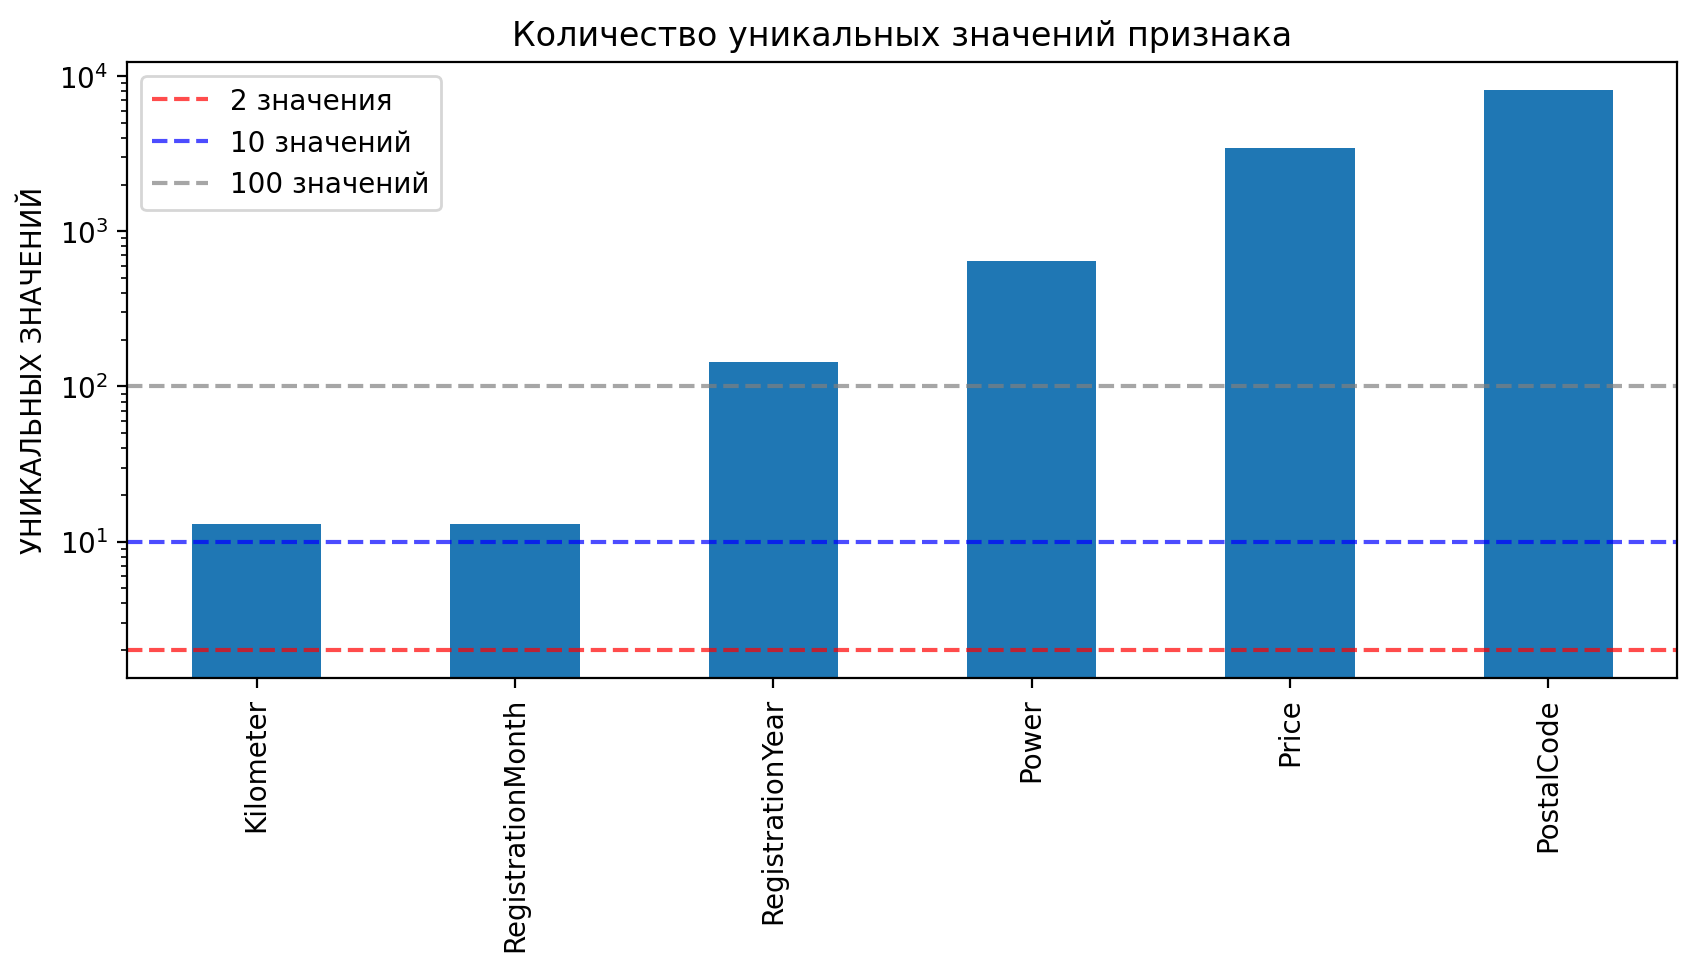

In [39]:
# для каждого числового столбца посчитаем количество уникальных значений и отсортируем
unique_values = df[numerical_columns].nunique().sort_values()

# Построим график с логарифимческой шкалой
unique_values.plot.bar(
    logy = True, figsize = (10, 4),
    title = 'Количество уникальных значений признака'
);

# добивим горизонтальные линии для значений 2 и 10, чтобы визуализировать бинарные и 
# дискретные признаки 
plt.axhline(2, color='red', alpha=0.7, linestyle='dashed')
plt.axhline(10, color='blue', alpha=0.7, linestyle='dashed')

# добавим линию сетки для значения 100
plt.axhline(100, color='gray', alpha=0.7, linestyle='dashed')

plt.ylabel('Уникальных значений'.upper())
plt.legend(['2 значения', '10 значений', '100 значений'])
plt.show()

Видим, что признак `Kilometer` имеет чуть больше 10 уникальных значений, то есть является дискретным. 

`RegistrationMonth` ожидаемо имеет 13 значений (12 месяцев и ноль).

Отметим, что количество уникальных значений для признака `RegistrationYear` намного больше ожидаемого из логики, что на продажу выставляются атомобили возрастом до нескольких дестятков лет.

Отметим, что можность двигателя представляена примерно 600-ми уникальных значений, а цена — 3-мя тысячами уникальных значений. 

Наибольшим разнообразием отличаются значения почтовых индексов.

##### Выводы

Мы выяснили, что наши данные представленны числовыми, категориальными и временными признаками.

Один признак содержит только нули и мы сразу можем исключить его из анализа. 

Среди остальных признаков мы ожидаем увидеть неявные пропуски и аномалии в значениях. 

#### Качество данных

На этом этапе оценим общее качество данных в датасете: дубликаты, пропуски, ошибки заполнения.

##### Дубликаты

In [40]:
duplicates_number = df.duplicated().sum()
print(f'Нашли {duplicates_number} дубликатов в датасете.')

Нашли 4293 дубликатов в датасете.


Дубликаты появлились после округления даты и времени загрузки объявления до дней. Видим, что некоторые объявляения были загружены несколько раз.

Дубликаты нам не нужны, удалим.

In [41]:
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(279202, 16)

##### Пропуски

На этапе обзора структуры данных, мы видели пропуски в категориальных признаках, а также неявные пропуски в численных. 

Оценим долю пропущенных значений в датасете.

In [42]:
(df[datetime_columns + categorical_columns].isna().sum() /
 df.shape[0]).sort_values(ascending=True)

DateCrawled    0.000000
DateCreated    0.000000
LastSeen       0.000000
Brand          0.000000
Model          0.056300
Gearbox        0.056332
FuelType       0.093753
VehicleType    0.106529
NotRepaired    0.202345
dtype: float64

In [43]:
((df[numerical_columns] == 0).sum() / df.shape[0]).sort_values(ascending=True)

RegistrationYear     0.000000
Kilometer            0.000000
PostalCode           0.000000
Price                0.030533
RegistrationMonth    0.105845
Power                0.114082
dtype: float64

Мы видим пропуски в признаках `Model`, `Gearbox`, `FuelType`, `VehicleType`, `NotRepaired`, `Price`, `RegistrationMonth`, `Power`.

Самыми критичными являются пропуски целевого признака, но таких объектов только 3%.

Количество объектов с пропусками модели и типа трансмиссии 5,6%. 

Примерно у 10% объектов есть пропуски в типе топлива, типе кузова, месяце регистрации и мощности двигателя.

Больше всего пропусков признака `NotRepaired` — 20%. 

Оценим распределение пропусков по объектам.

In [44]:
nan_columns = ['Price', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'RegistrationMonth', 'Power']

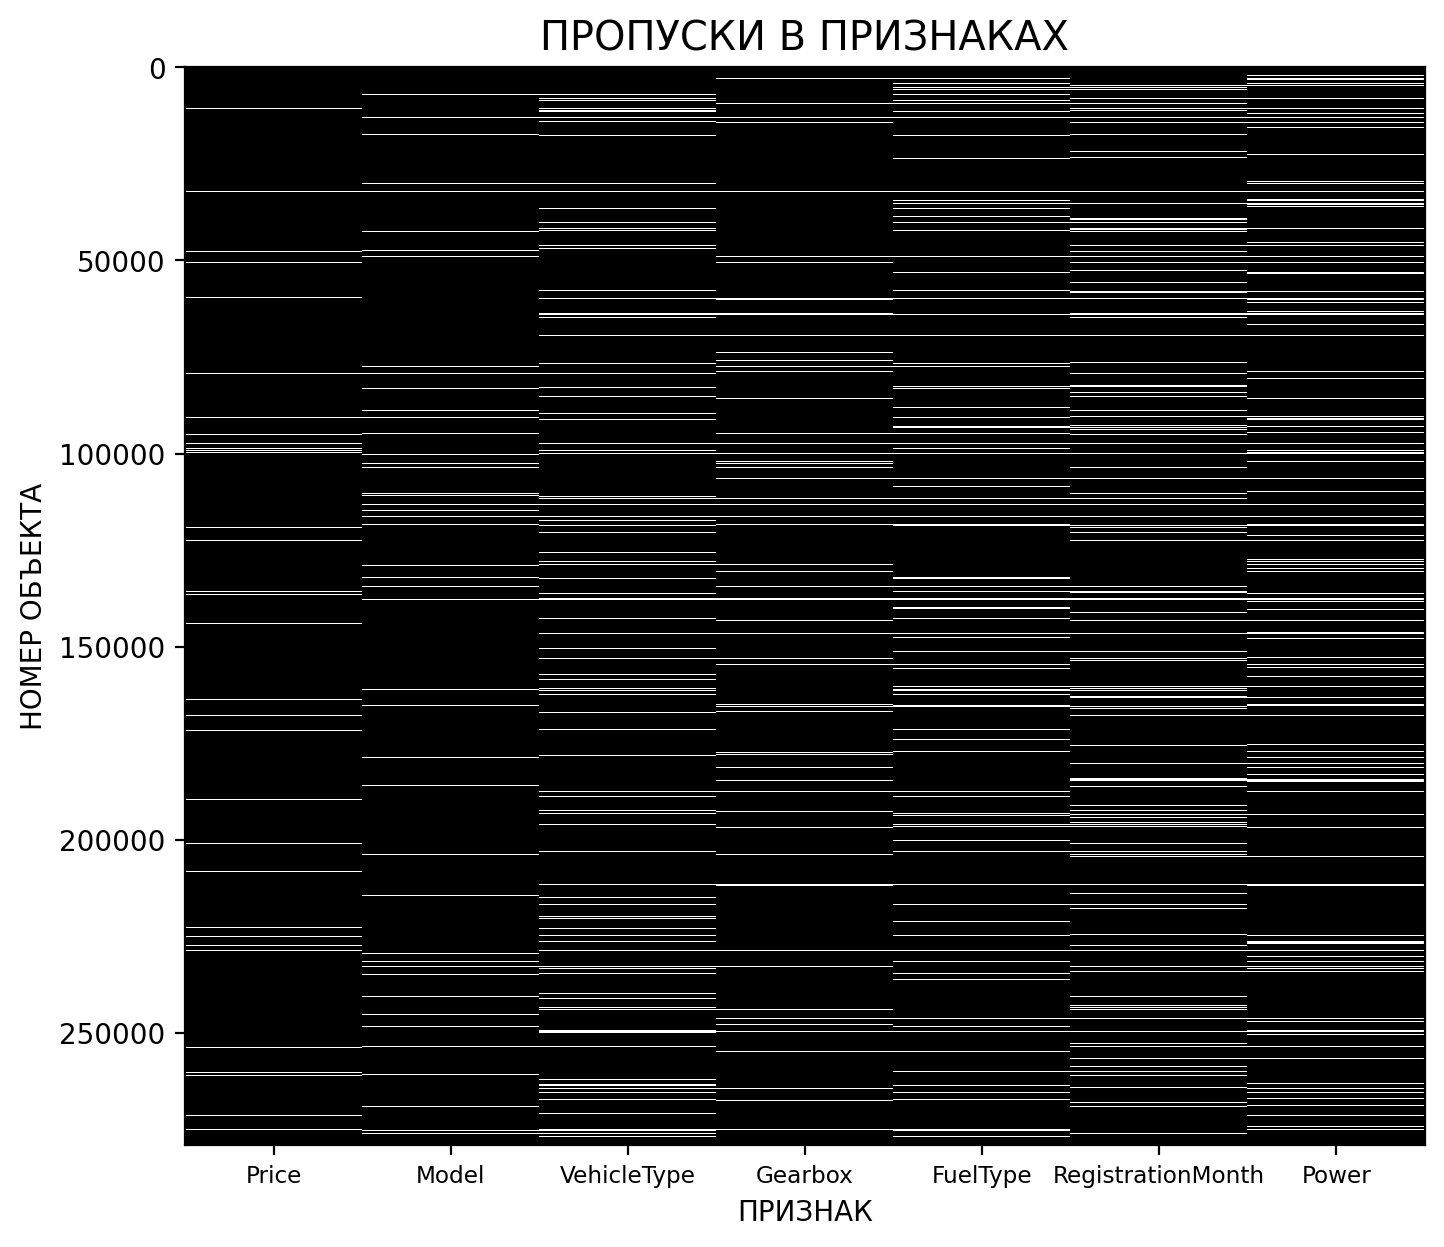

In [45]:
plt.figure(figsize=(8, 7))
plt.imshow((df[nan_columns].isna()) |
           (df[nan_columns] == 0),
           aspect='auto',
           interpolation='nearest',
           cmap='gray')
plt.xlabel('Признак'.upper())
plt.xticks(ticks=range(len(nan_columns)),
           labels=nan_columns,
           fontsize='small')
plt.ylabel('Номер объекта'.upper())
plt.title('Пропуски в признаках'.upper(), fontsize='x-large')
plt.show()

Видим, что пропуски распределены по датасету более-менее равномерно, без явных паттернов.

Есть объекты с пропусками в нескольких признаках, представленные горизонтальные прямыми. То есть в нашем датасете есть объекты, для которых известны только бренд автомобилия и пробег.

Также есть объеты с пропусками одного или нескольких признаков. Возможно, для таких объектов у нас получится заполнить пропуски на основании значений других признаков.

Пропуски целевого признака мы не можем заполнить, поэтому удалим объекты с пропусками. Заполнение пропусков в остальных признаках мы сделаем после анализа значений признаков.

In [46]:
df = df[df.Price > 0]
df.shape

(270677, 16)

##### Ошибки заполнения числовых признаков

Проверим наш датасет на проблемы с заполнением числовых значений. 

Для каждого числового признака построим график, который визуализирует значения признака (ось Y) для каждого из объектов в датасете (ось X).

Мы ожидаем, что распределение значений будет охватывать весь диапазон по оси Y для всех объектов, то есть на всем протяжении оси X. 

Пробелы по оси X покажут ошибки заполнения значений, а визуальные паттерны будут говорить о характере заполнения датасета.

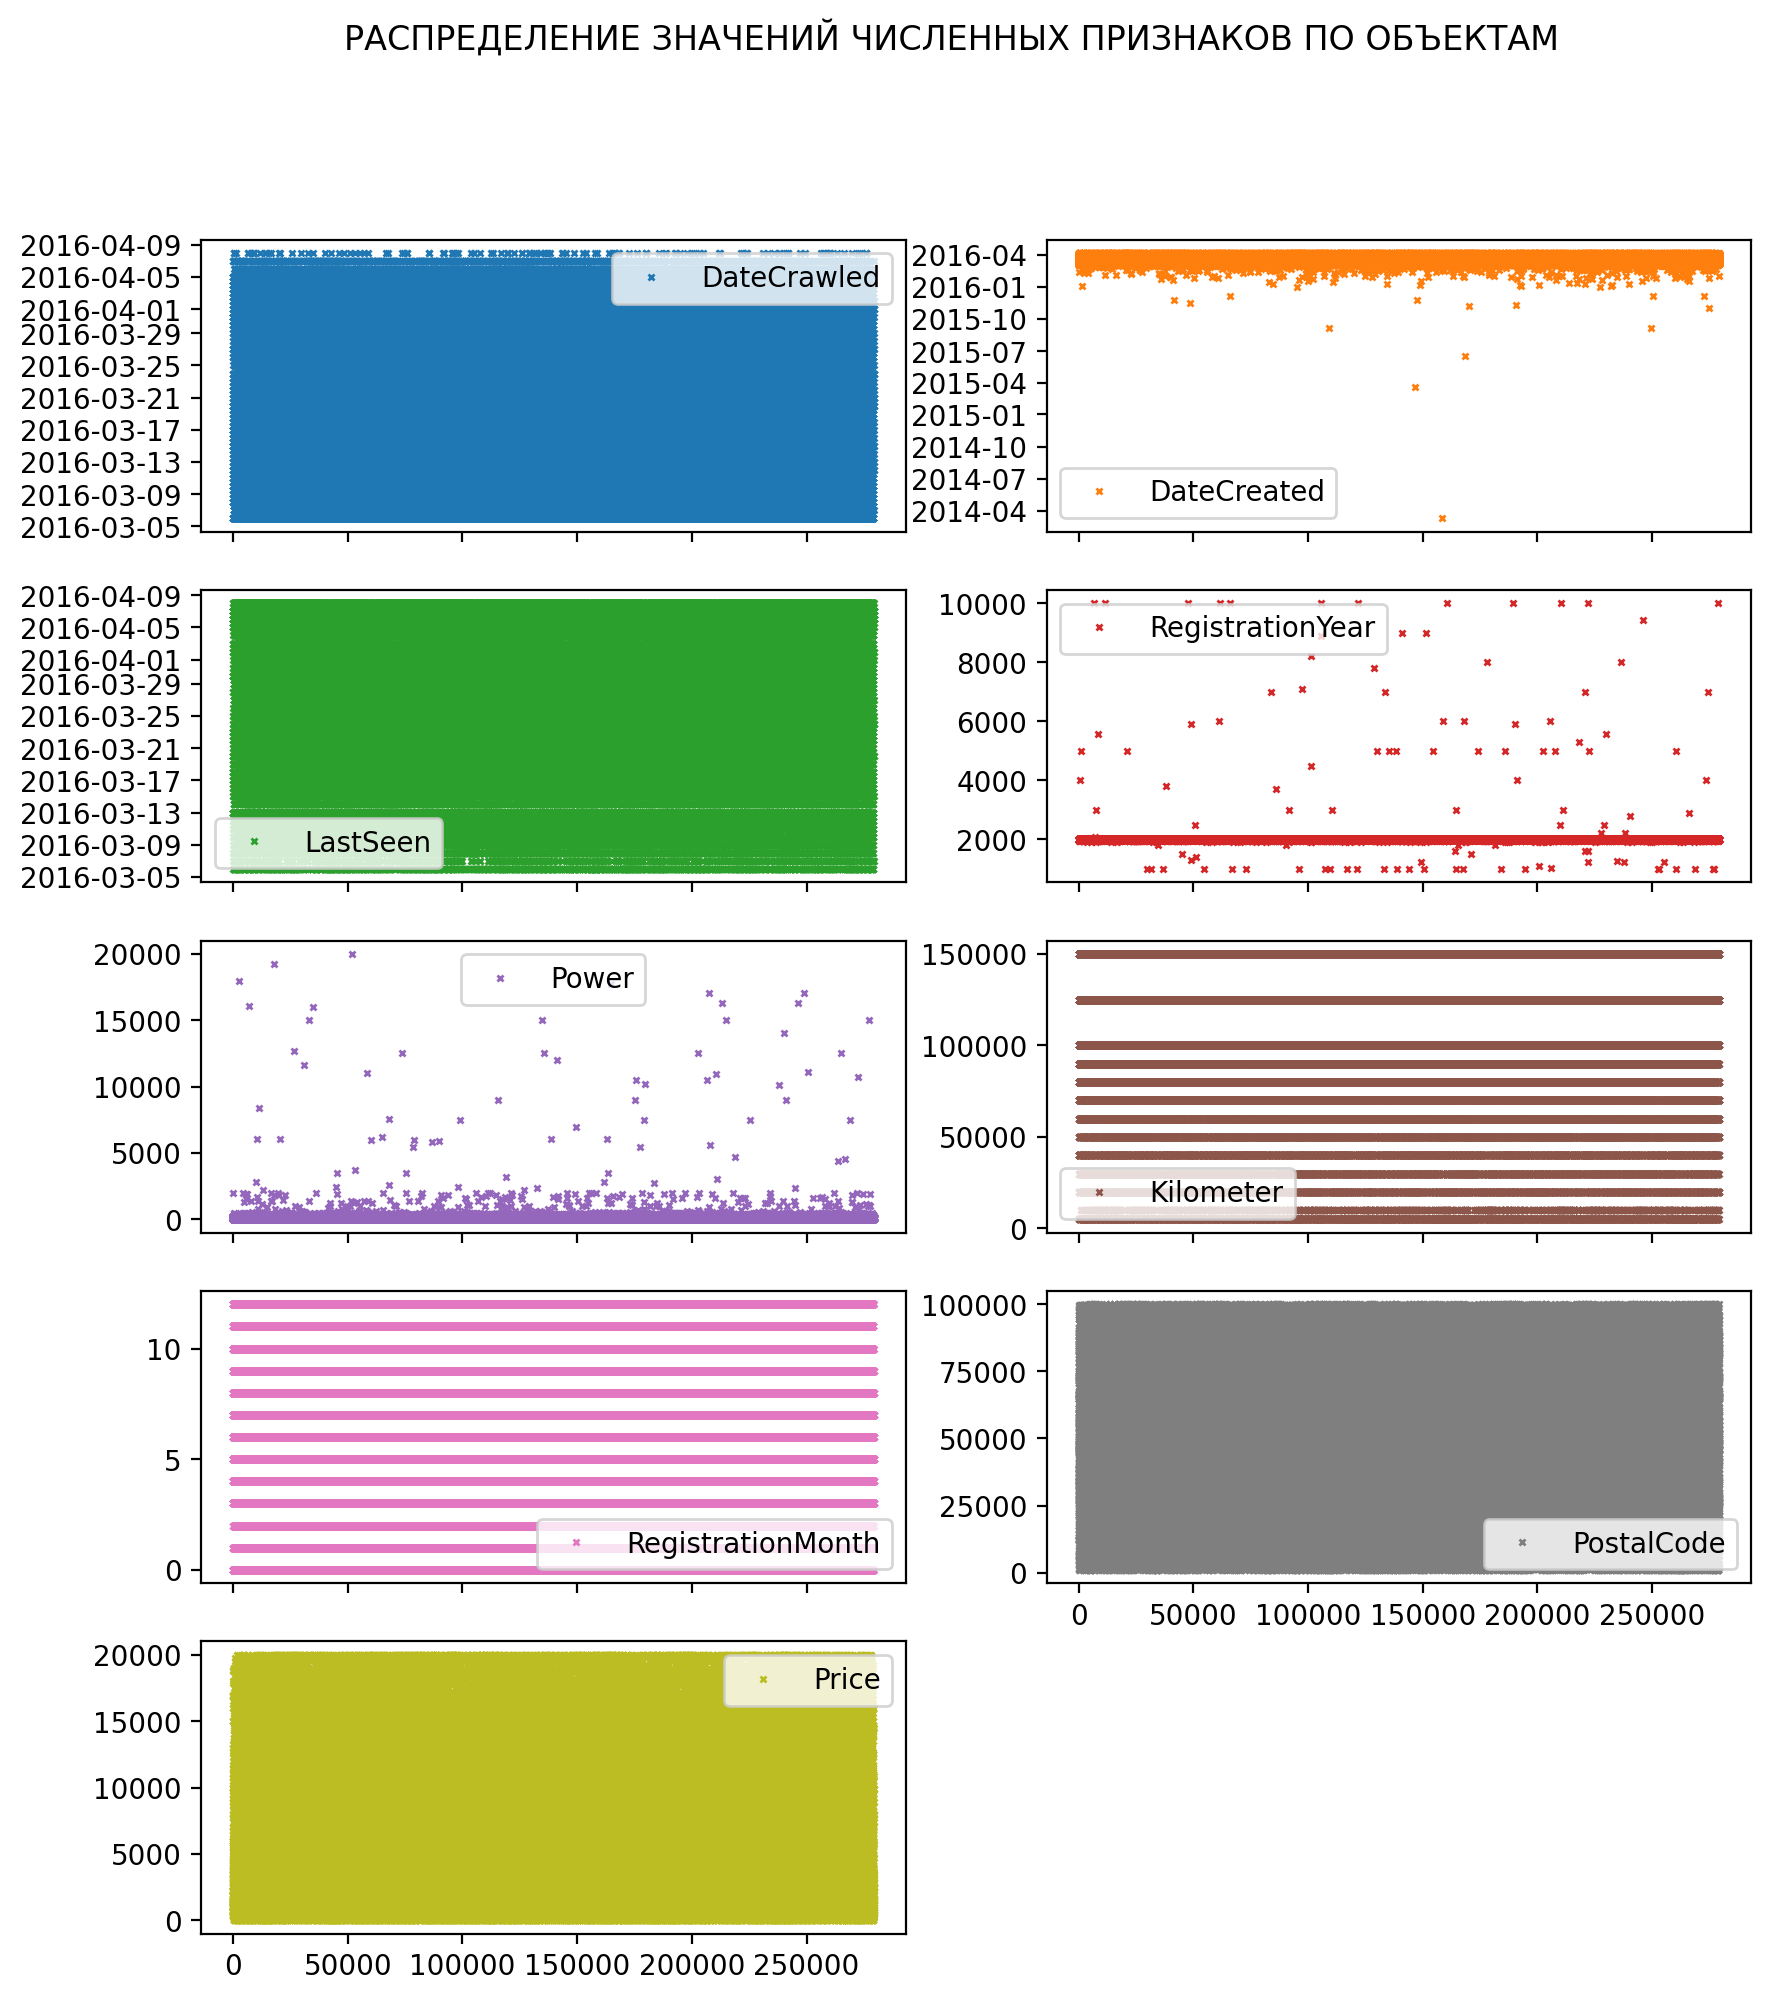

In [47]:
df[datetime_columns + numerical_columns].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 11), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
);

plt.show()

Мы не видим ошибок и паттернов в нашем датаесете, значения парамтров раномерно распределены по всем объектам. 

Редкие нерпавдоподобные значения для `RegistrationYear` и `Power` встречаются равномерно, что говорит об ошибках в самих анкетах, а не в принципе их сбора. 

##### Выводы

Мы обнаружили в данных дубликаты и удалили их. 

Мы изучили явные и неявные пропуски в признаках. Объекты с пропущенными значениями целевого признака мы сразу исключили из дальнейшего анализа. Метод устрания пропусков мы сформулируем после проведения исследовательского анализа данных.

Ошибки и паттерны в датасете мы не обнаружили, что говорит о корректности сбора данных.

#### Анализ значений

##### Время

В нашем датасете есть три признака, описывающих время: дата загрузки анекты, дата создания анкеты и дата последнего просмотра анкеты.

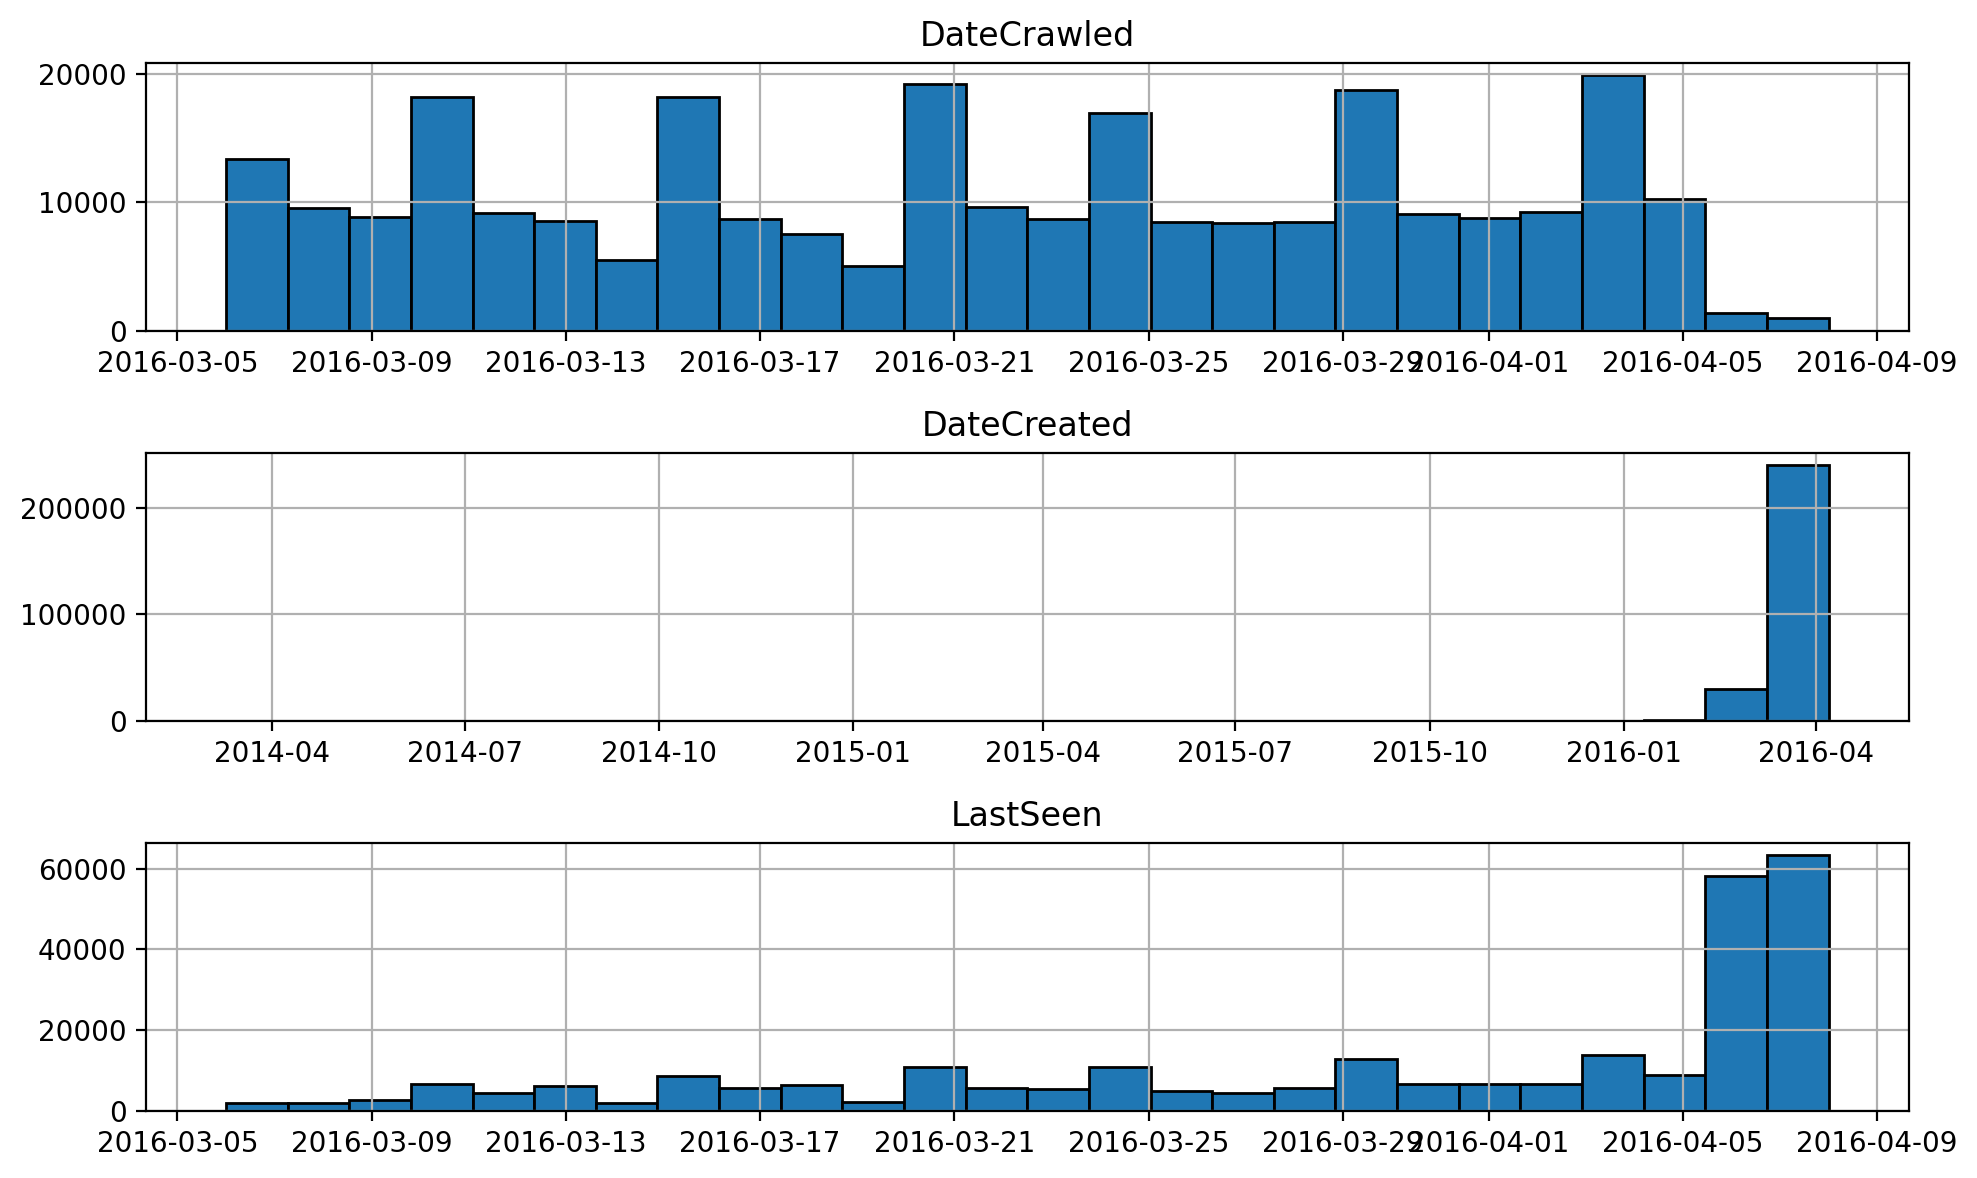

In [48]:
df[datetime_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 1),
                           edgecolor="black")
plt.tight_layout()
plt.show()

Мы видим, что сбор анкет началася в марте 2016 года и закончился в апреле 2016 года, продолжался чуть более месяца.

Большинство собранных анкет было создано в марте-апреле 2016 года, что совпадает с датами сбора. То есть большинство анкет было собрано сразу после создания.

На этот же период выпадает и большинство просмотров анкет, что похоже на запуск сервиса в апреле 2016 года.

Рассчитаем и проанализируем возраст анкет в днях.

In [49]:
df['AnketaAge'] = (df.DateCrawled - df.DateCreated).astype('timedelta64[D]')

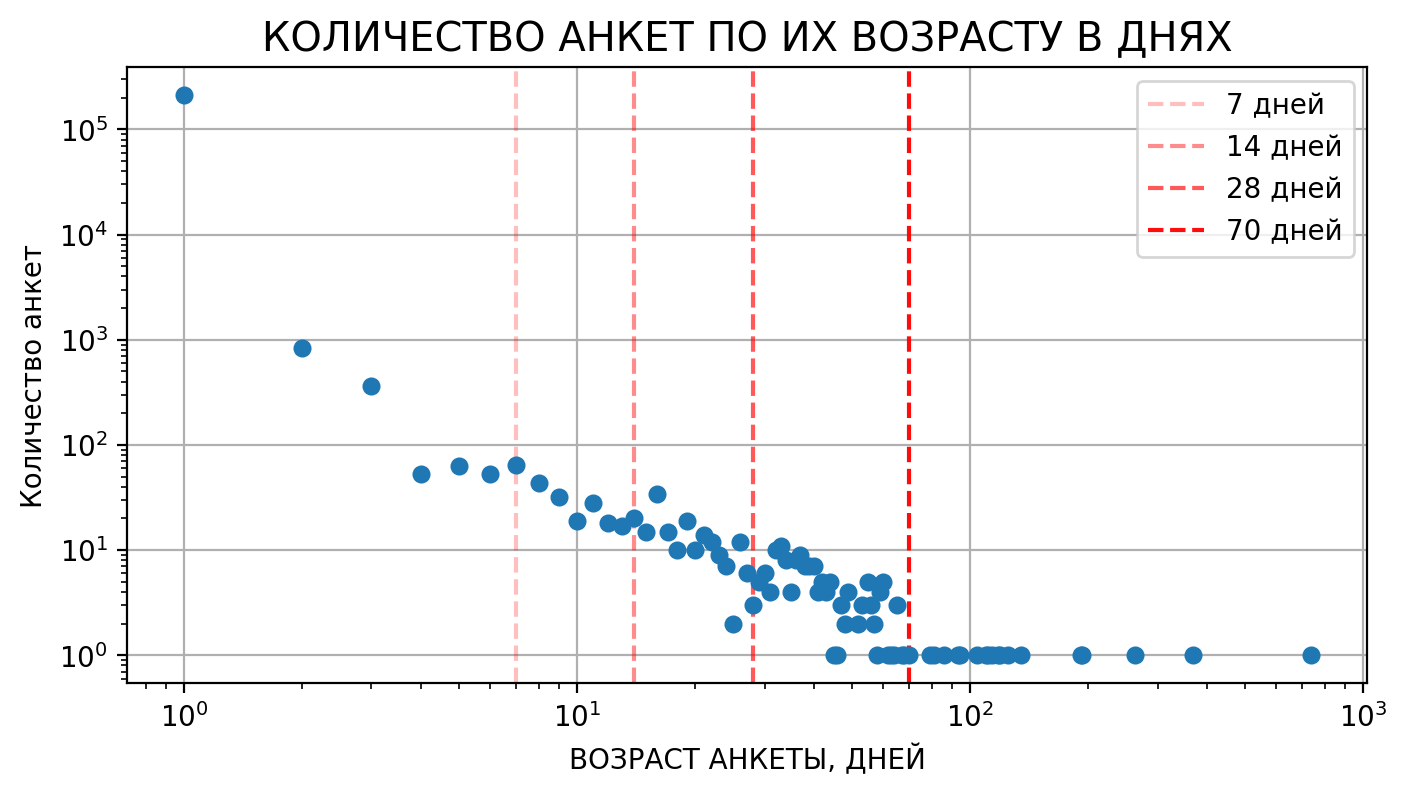

In [50]:
plt.axvline(7, c='r', alpha=.25, linestyle='dashed')
plt.axvline(14, c='r', alpha=.45, linestyle='dashed')
plt.axvline(28, c='r', alpha=.65, linestyle='dashed')
plt.axvline(70, c='r', alpha=.95, linestyle='dashed')

df.AnketaAge.value_counts(sort=False).sort_index().plot(lw=0,
                                                        marker='.',
                                                        markersize=11,
                                                        logy=True,
                                                        logx=True,
                                                        figsize=(8, 4),
                                                        grid=True)

plt.title('Количество анкет по их возрасту в днях'.upper(), fontsize='x-large')
plt.xlabel('Возраст анкеты, дней'.upper())
plt.ylabel('Количество анкет')
plt.legend(['7 дней', '14 дней', '28 дней', '70 дней'])
plt.show()

Мы видим, что 200 тысяч акет имеют возраст 1 день, далее до 70 дней мы видим быстро уменьшающееся количество анкет с увеличеним возраста, и в конце несколько десятков анкет с возрастом более 70 дней.

В целом наш датасет содрежит актуальные акеты. Подозрительно выглядит только анкета с возрастом больше года. Посмотрим на нее.

In [51]:
df[df.AnketaAge > 365].T

,146707,158311
DateCrawled,2016-03-24 00:00:00,2016-03-16 00:00:00
VehicleType,bus,NaN
RegistrationYear,1995,2005
Gearbox,auto,NaN
Power,200,0
Model,other,147
Kilometer,150000,125000
RegistrationMonth,0,0
FuelType,petrol,petrol
Brand,chevrolet,alfa_romeo


Не видим ничего криминального.

Признак `LastSeen` не имеет отношение к анализируемым объектам, в дальнейшем его рассматривать не будем. 

Признак `DateCreated` позволит нам посчитать возраст автомобиля на следующем шаге.

##### Числовые признаки

Построим гистограммы и бокс-плоты для числовых признаков.

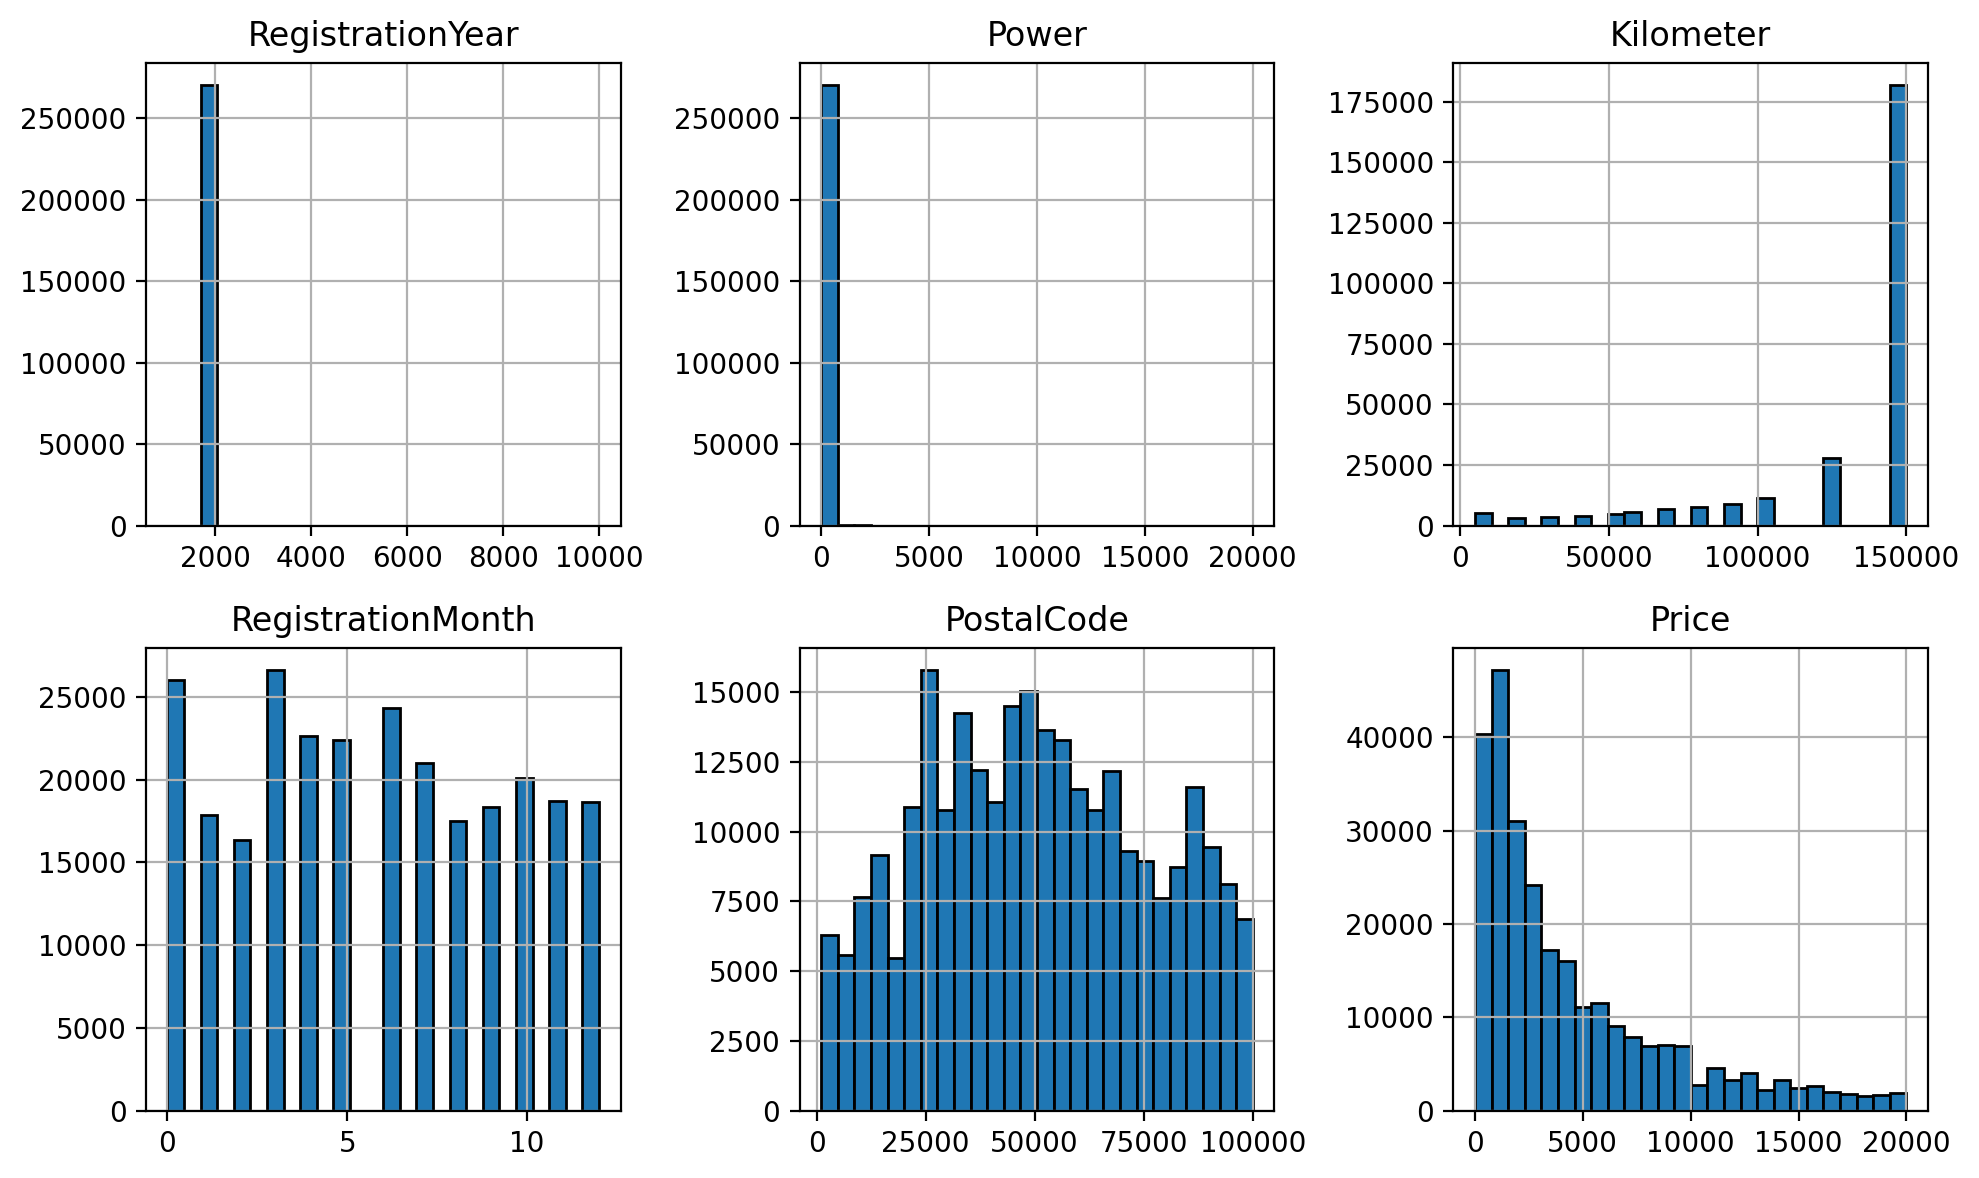

In [52]:
df[numerical_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 3),
                           edgecolor="black")
plt.tight_layout()
plt.show()

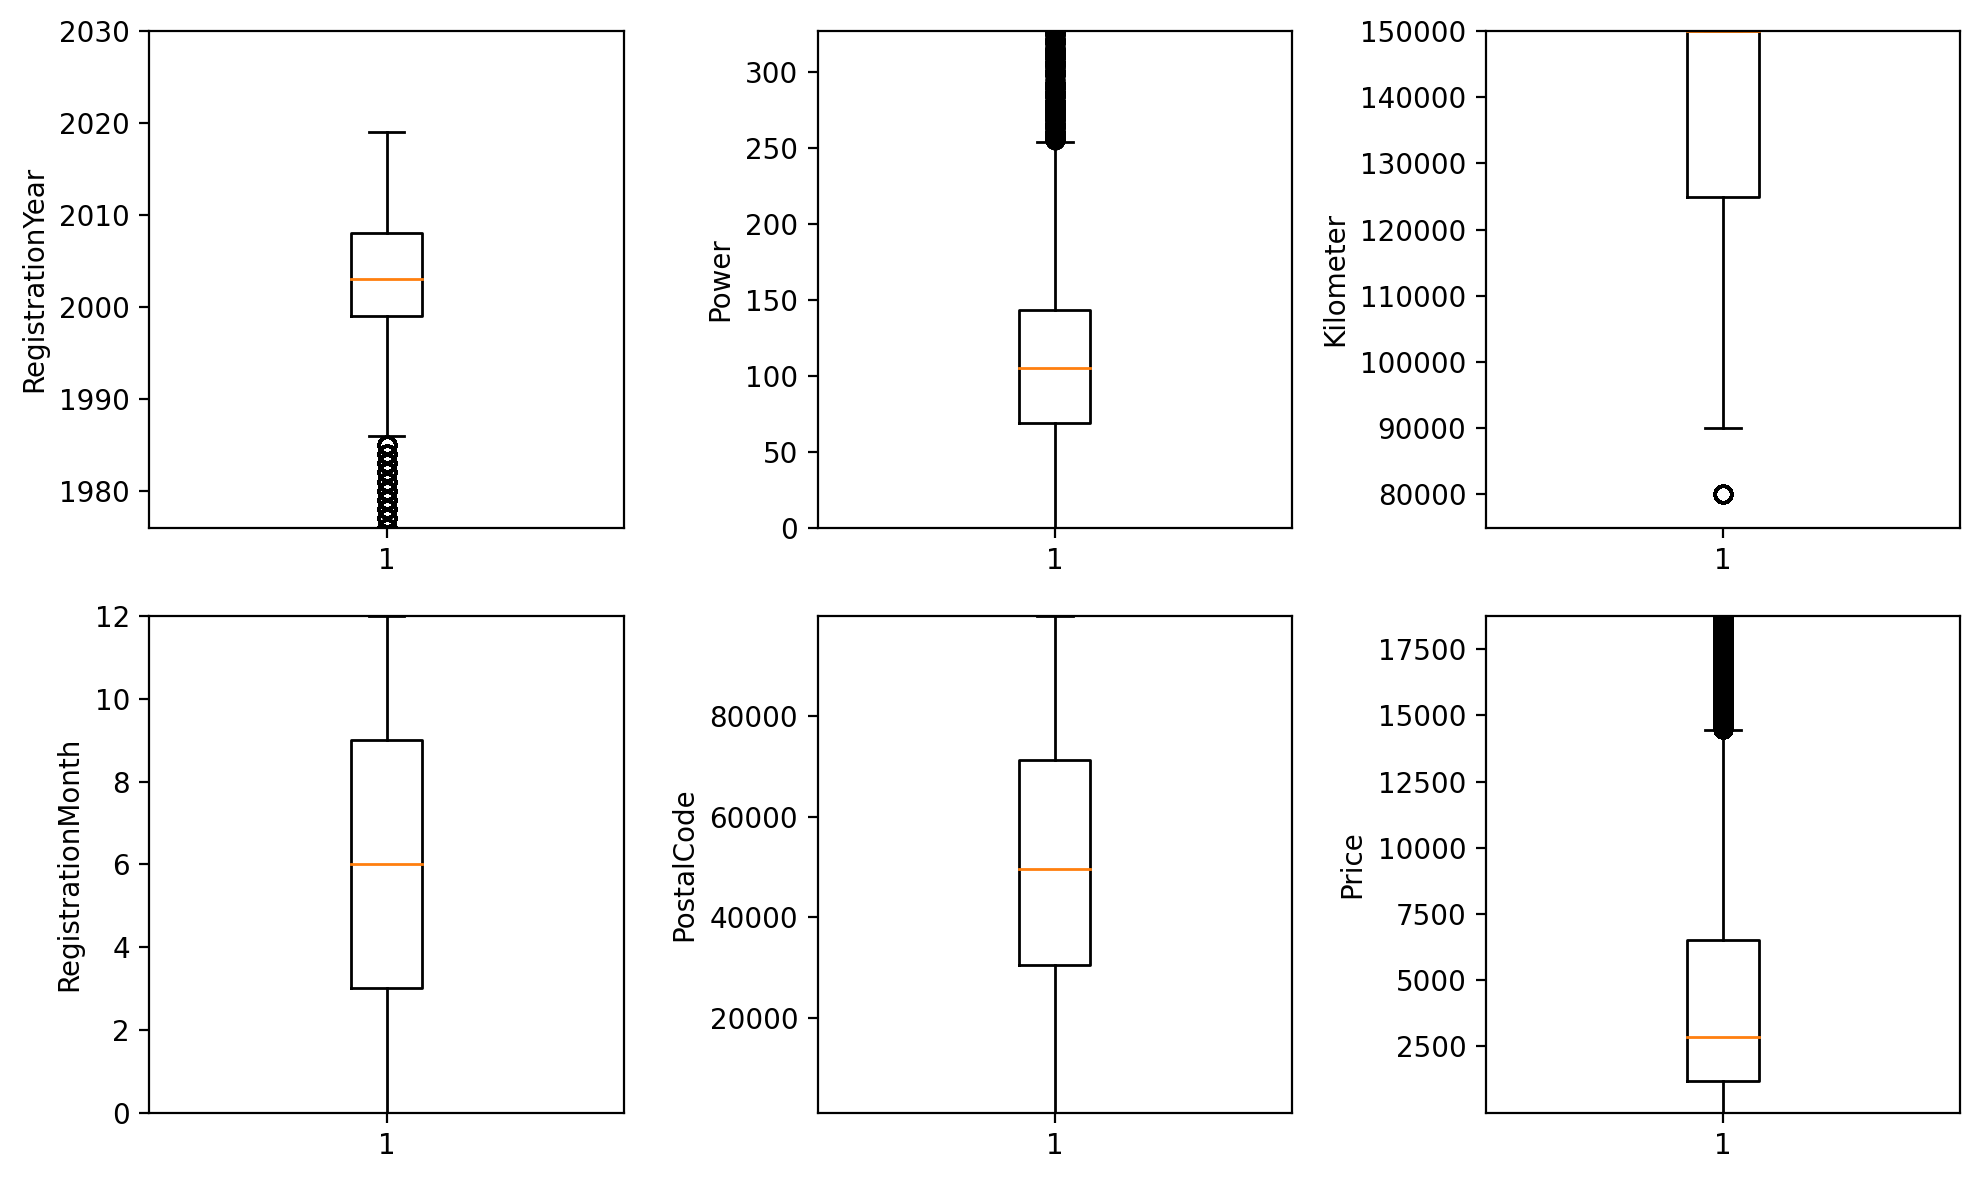

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

def draw_boxplot(ax, x, column_name, ylabel):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    median = x.median()
    data_range = (
        max(x.min(), median-3*iqr),
        min(x.max(), median+3*iqr)
    )
    ax.boxplot(x=x)
    ax.set_ylim(data_range)
    ax.set(ylabel=column)
    
for column, ax in zip(numerical_columns, axes.ravel()):
    draw_boxplot(ax, df[column], column, 'label')
plt.tight_layout()
plt.show()

Распределение цены похоже на логнормальное, для которого нормальным является длинный хвост значений. Аномалий в значениях мы не наблюдаем.

У пробега распределение тоже похоже на логнормальное, но умноженное на -1 и смещенное на 150000. Аномалий в значениях мы не наблюдаем.

Также не видим аномалий в распределении значений `RegistraionMonth` и `PostalCode`. 

Только `RegistrationYear` и `Power` имеют выборосы с большим диапазоном значений. Проанализируем эти признаки. 

**ГОД РЕГИСТРАЦИИ АВТОМОБИЛИЯ**

Перейдем от признаков `RegistrationYear` и `RegistrationMonth` к признаку возраст автомобиля `CarAge` на дату публикации объявления в целом количестве лет. При этом пренебрежем ошибкой в 1 месяц, которая будет возникать для объектов с `RegistrationMonth`, равным нулю.

In [54]:
df['CarAge'] = round(
    (df.DateCreated.dt.year * 12 + df.DateCreated.dt.month -
     df.RegistrationYear * 12 - df.RegistrationMonth) / 12).astype('int')
df[['RegistrationYear', 'RegistrationMonth', 'DateCreated', 'CarAge']].head()

,RegistrationYear,RegistrationMonth,DateCreated,CarAge
0,2010,12,2016-03-14,5
1,2011,6,2016-03-18,5
2,2004,10,2016-03-28,11
3,2004,4,2016-03-28,12
4,2000,4,2016-03-30,16


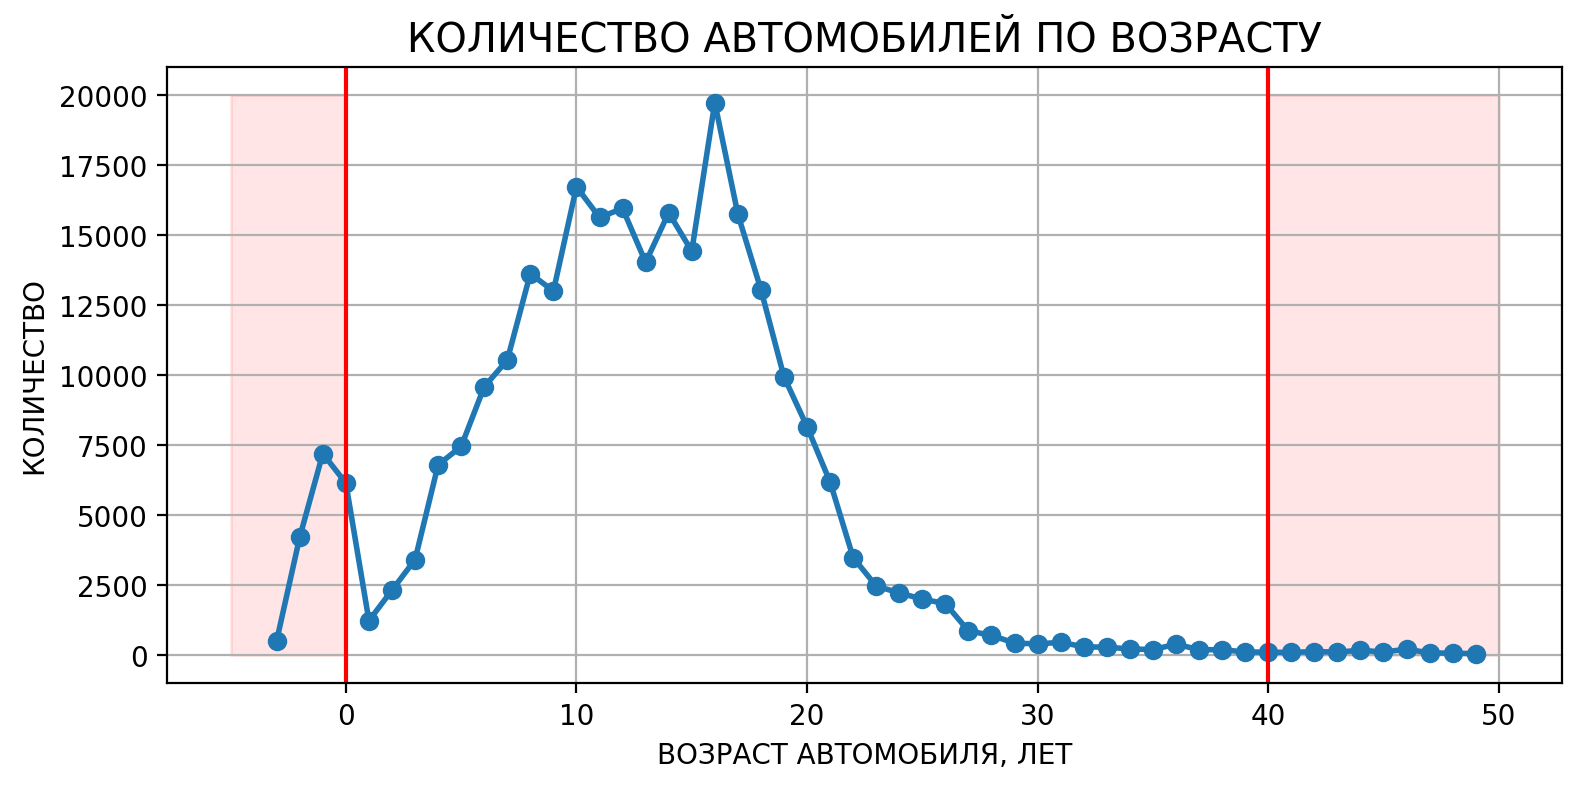

In [55]:
df.loc[(df.CarAge > -5) & (df.CarAge < 50),
       ['CarAge', 'Price']].groupby(['CarAge']).count().plot(lw=2,
                                                             marker='o',
                                                             figsize=(9, 4),
                                                             grid=True,
                                                             legend=None)
plt.axvline(0, c='r')
plt.axvline(40, c='r')
plt.fill_between([-5, 0], 20000, color='r', alpha=.1)
plt.fill_between([40, 50], 20000, color='r', alpha=.1)
plt.title('Количество автомобилей по возрасту'.upper(), fontsize='x-large')
plt.ylabel('Количество'.upper())
plt.xlabel('Возраст автомобиля, лет'.upper())
plt.show()

После 30 лет количество объявлений практически сливается с осью х. Согласно [American Collectors Community](https://americancollectors.com/articles/vintage-vs-classic-vs-antique-cars/) автомобили возрастом страше 20 лет относятся к классу ClassicCars, а старше 45 лет относятся к классу Antique Car. Поскольку это уже специфические коллекционные автомобили, ограничим область примерения нашей модели верхним возрастом. 

Посмотрим, как изменяется цена в зависимости от возраста автомобилия. Обратим внимание как на объявления, в которых год регистрации автомобилей больше года создания объявления, то есть в будущем, так и на старые автомобили.

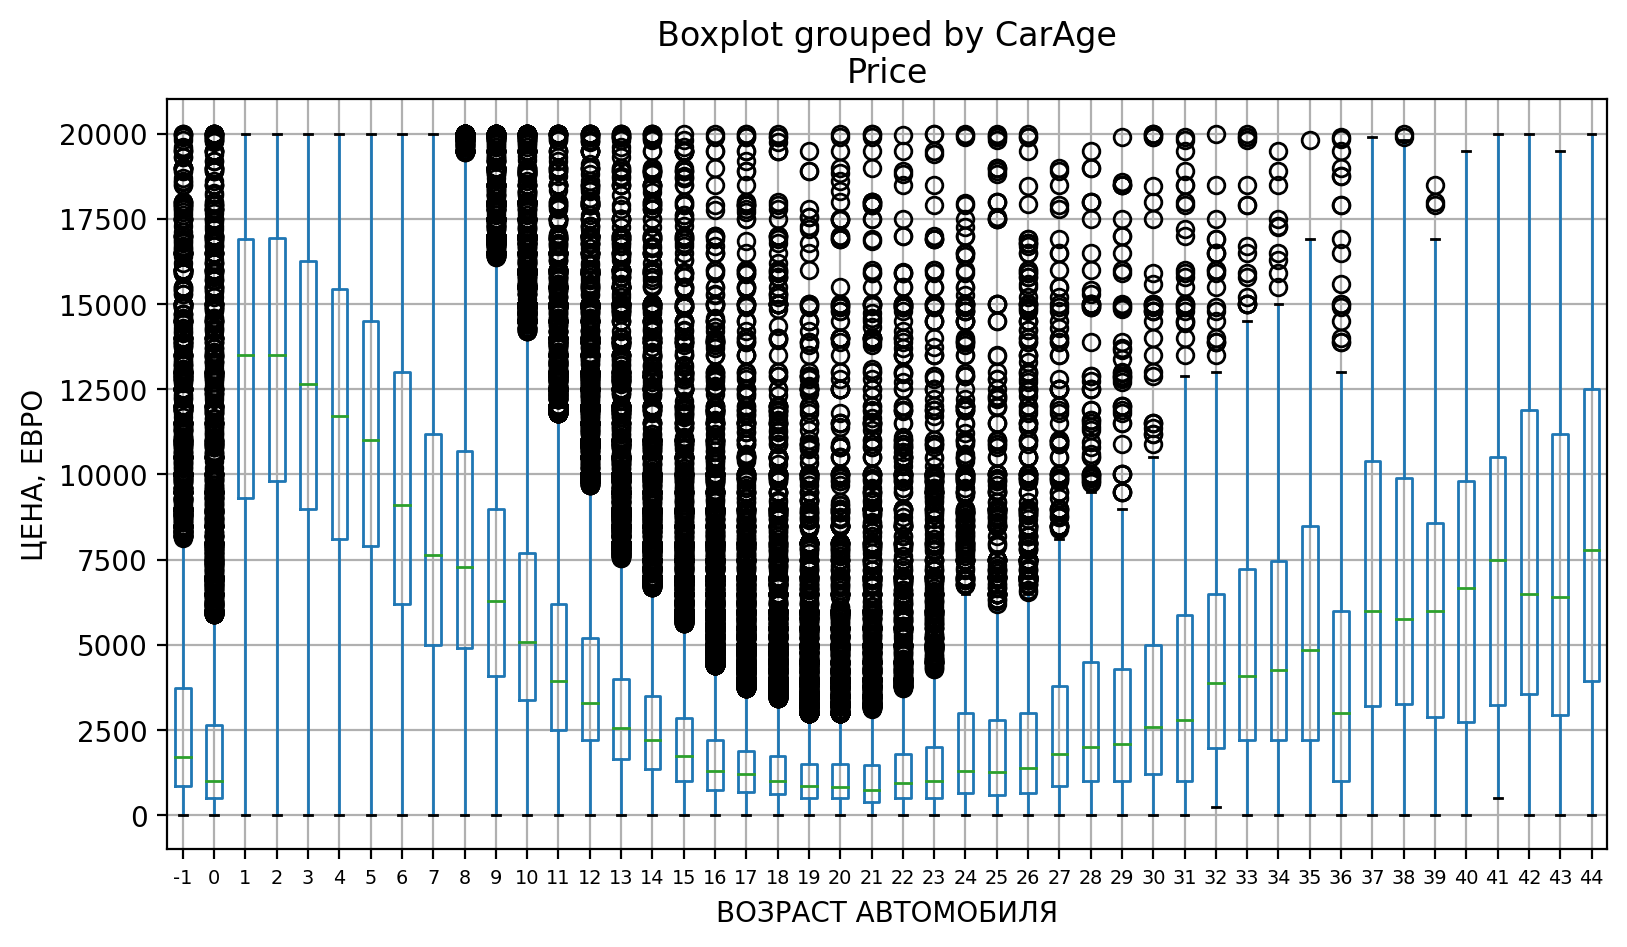

In [56]:
df.loc[(df.CarAge > -2) & (df.CarAge < 45),
       ['CarAge', 'Price']].boxplot(column='Price',
                                    by='CarAge',
                                    figsize=(9, 5))
plt.xlabel('Возраст автомобиля'.upper())
plt.xticks(fontsize='x-small')
plt.ylabel('Цена, евро'.upper())
plt.show()

Здесь мы видим, что для возраста 0 и -1 цена намного меньше, чем для возраста 1, 2 года. Значит мы не можем сказать, что 0 — это новый автомобиль. Тогда нижняя граница возраста для нашей модели будет 1 год.

Межквартильное расстояние с ростом возраста автомоббиля уменьшается, что говорит об уменьшении разброса цен. Отклонения встрачаются редки и мы видим их за пределами усов боксплота. Наименьшее межквартильное расстояние мы видим для возраста 19–21 год. Потом разброс цены снова растет. 

После 39 лет исчезают выбросы, то есть количество объявлений становится небольшим, а разброс значений большим. 

Ограничим верхний возраст автомобиля для нешей модели 39 годами.

**МОЩНОСТЬ**

В данных мы видим редкие неправдоподобные значения мощности автомобилией. Учитывая, что 
- мощность двигателей соврменных топовых коммерческих авто до 500лс ([источник hotcars.com](https://www.hotcars.com/most-powerful-engines-ever-fitted-production-cars/)), 
- наш сервис ориентирован на массовый сегмент, поэтому спорткары с мощностью до 1700 лс не рассматриваем,
- на боксплоте мы видим, что значения более 250 лс уже находятся в зоне вылетов,

примем значения выше 500 лс ошибочными. 

**ЦЕНА**

Посмотрим, как в нашем датасете растет цена по объектам: упорядочим все объекты по росту цены и построим график цены от номера объекта. 

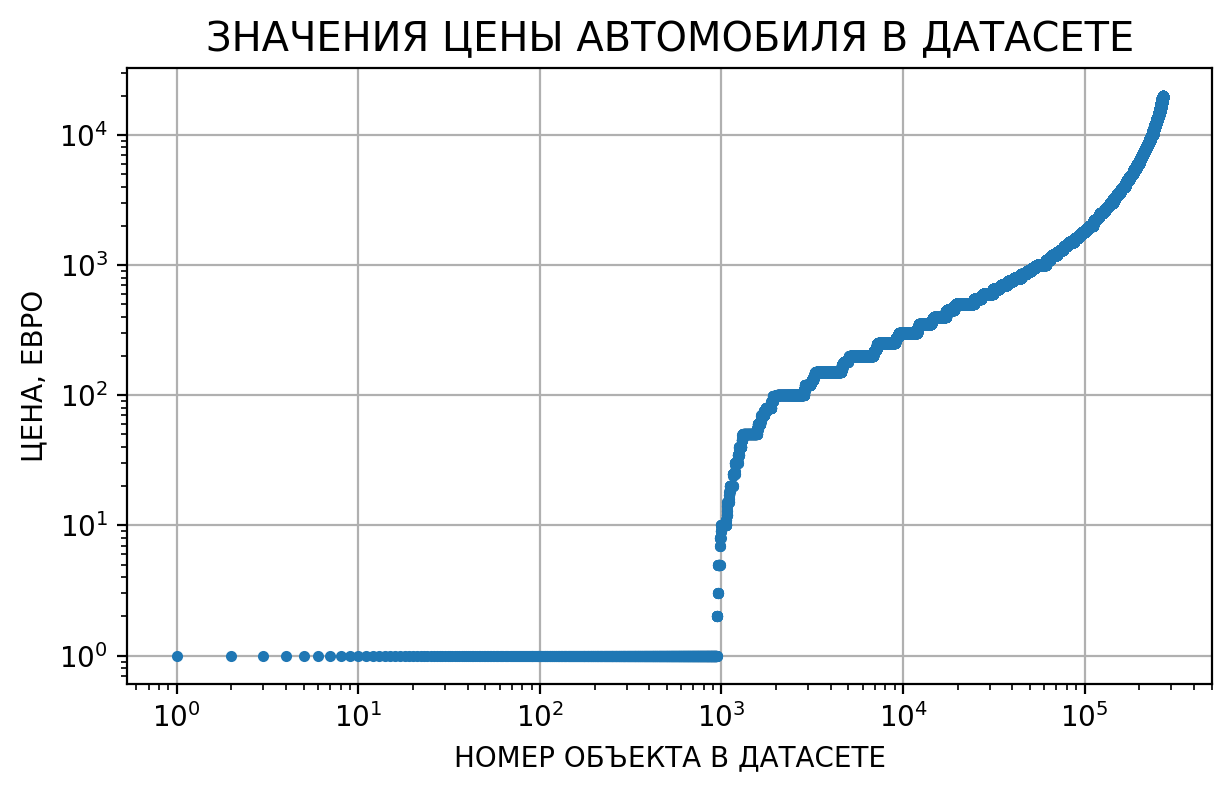

In [57]:
fig = plt.figure(figsize=(7, 4))
plt.plot(range(df.shape[0]),
         df.Price.sort_values(),
         marker='o',
         lw=0,
         ms=3)
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.title('Значения цены автомобиля в датасете'.upper(), fontsize='x-large')
plt.ylabel('Цена, евро'.upper())
plt.xlabel('Номер объекта в датасете'.upper())
plt.show()

Мы видим, что в датасете есть 1000 объектов с ценой 1 евро и еще 1000 с ценой меньше 100 евро. Выглядит очень странно при том, чтосредняя [цена на 10-летний автомобиль](https://www.statista.com/statistics/589613/average-prices-for-used-cars-germany/#statisticContainer) в Германии около 7000 евро. 

Однако на сайте [autoscout24.de](https://www.autoscout24.com/lst?sort=price&desc=0&atype=C&ustate=N%2CU&powertype=kw&priceto=500&search_id=vslwgpr1pq) действительно есть 1000 объявлений с ценой 1 евро. 

На этом сайте мы видим и большое количество объявлений со старыми автомобилями и ценой в несколько сот евро, которые в действительностости представляют собой объявления о запчастях: [детали кузова](https://www.autoscout24.com/offers/studebaker-others-gasoline-silver-d7ca786c-8975-4c3e-9e1d-b5356d06f897?sort=price&desc=0&lastSeenGuidPresent=false&cldtidx=14&position=14&search_id=1ccky7t01lx&source_otp=t10&source=listpage_search-results), [мотор](https://www.autoscout24.com/offers/bmw-2002-motore-gasoline-grey-19ac5d4a-d439-4f56-9196-39d23b2971d2?sort=price&desc=0&lastSeenGuidPresent=false&cldtidx=42&position=42&search_id=1ccky7t01lx&source_otp=t10&source=listpage_search-results), [старый кузов с деталями](https://www.autoscout24.com/offers/fiat-500-gasoline-blue-6b609281-ae3a-4b58-8a55-2be781c0abb7?sort=price&desc=0&lastSeenGuidPresent=false&cldtidx=11&position=11&search_id=1ccky7t01lx&source_otp=t10&source=listpage_search-results).

Отметитим, что в объявлениях с "запчастями" на [autoscout24.de](https://www.autoscout24.de/) не заполнены признаки, пропуски в которых мы налюдали и в нашем датасете: тип кузова, тип коробки передач. 

##### Категориальные признаки

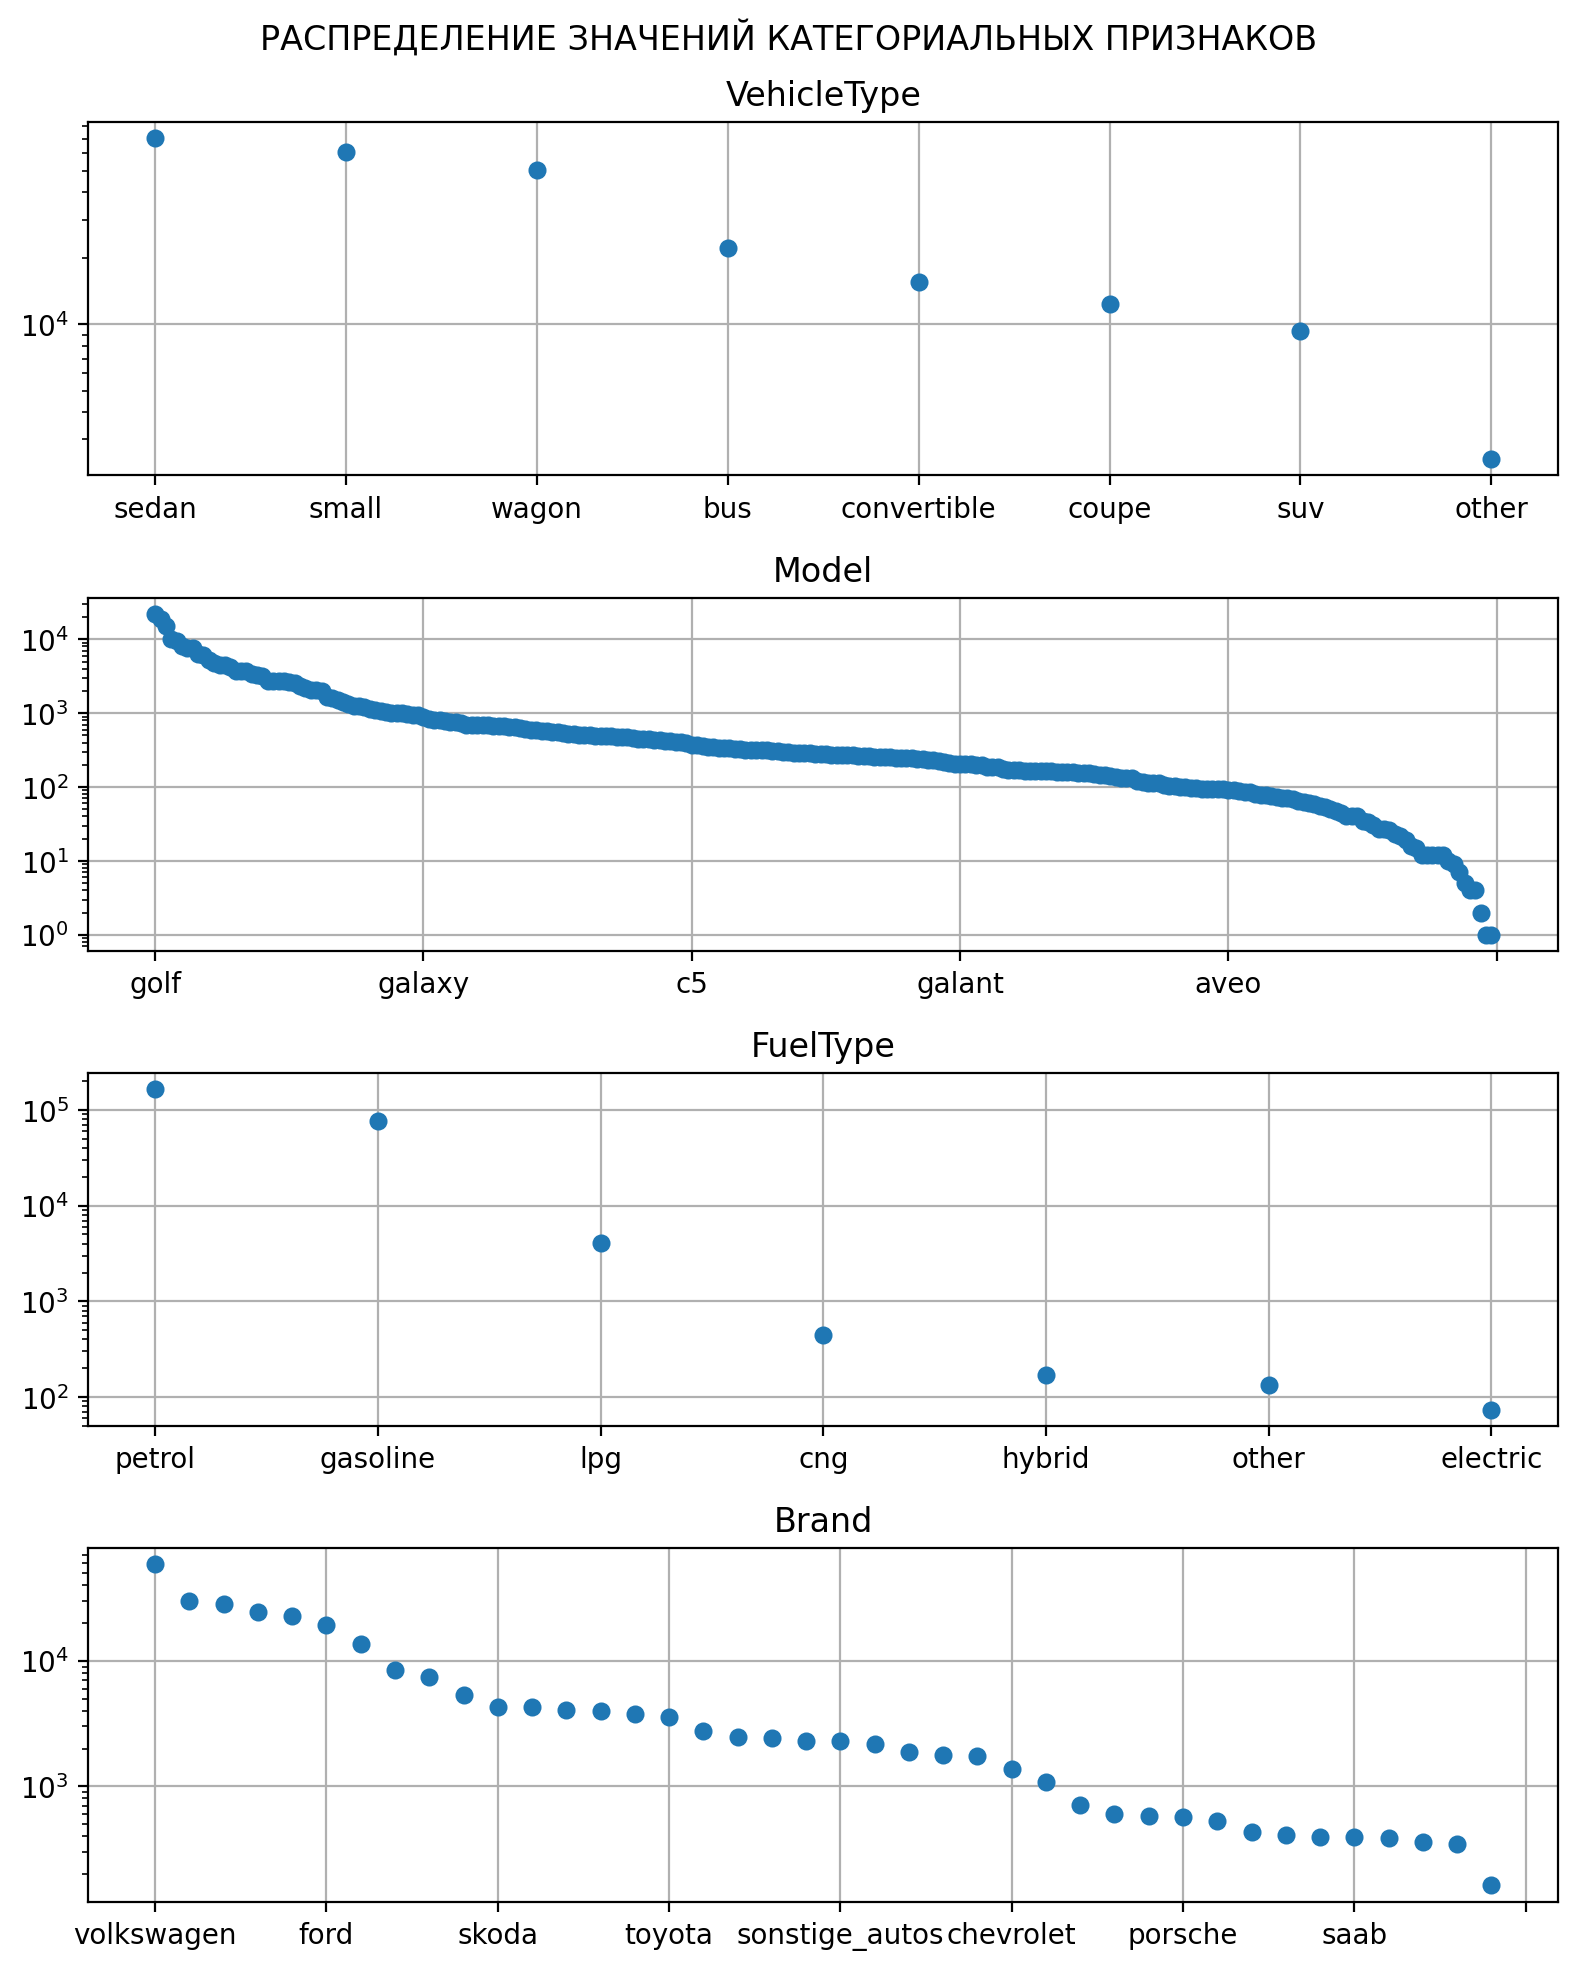

In [58]:
columns = [_ for _ in categorical_columns if _ not in ['Gearbox', 'NotRepaired']]

# Создадим фигуру с количеством графиков, равных количеству столбцов
fig, axes = plt.subplots(ncols=1,
                         nrows=len(columns),
                         figsize=(8, 10))

# Добавим в цикле график для каждого признака на соответсвующей оси
for col, ax in zip(columns, axes.ravel()):

    # Посчитаем количество уникальных значений признака
    df[col].value_counts().plot(

        # Отобразим на графике в логарифмической шкале
        logy=True,
        title=col,
        lw=0,
        marker='.',
        ax=ax,
        markersize=11,
        grid=True)

plt.suptitle('Распределение значений категориальных признаков'.upper())
plt.tight_layout()
plt.show()

**ТИП КУЗОВА**

Среди значений не видим аномалий. Намиеньшее количество объектов имеет значение other. 

**МОДЕЛЬ**

Характер графика количества объектов по моделям соответствует ожиданиям. Отметим небольшое количество моделей в самой правой части, для которых меньше 10 объявлений.

Визуально проверим значения на неявные дубли.

In [59]:
df.Model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Неявных дублей в значениях не видим. Формат названий един для всех моделей.

**ТИП ТОПЛИВА**

Отметим, что два самых распространных значения типа топлива в данных petrol и gasoline — это [одно и тоже](https://en.wikipedia.org/wiki/Gasoline). На [autoscout24.com](https://www.autoscout24.com/refinesearch?sort=standard&desc=0&ustate=N,U&atype=C) в фильтре видим только gasoline.

Електромобилей в 2016 году еще практически нет.

**БРЕНД**

Как и для модели, характер графика количества объектов по брендам соответсвует ожиданиям. 

Проверим значения на неявные дубли.

In [60]:
df.Brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Со значениями все в порядке. Отметим, что значение 'sonstige_autos' с немецкого переводится как 'other'.

Посмотрим, насколько уникальны модели по брендам.

In [61]:
(df[['Model', 'Brand']]
 .drop_duplicates()
 .groupby(by=['Model'])
 .count()
 .query('Brand > 1')
)

,Brand
Model,
1_reihe,2
3_reihe,2
5_reihe,2
defender,2
discovery,2
freelander,2
grand,3
matiz,2
other,39


39 брендов из 40 имеют модель other. Большинство моделей уникальны для бренда. 

Оценим влияние бренда и возраста автомобиля на цену.

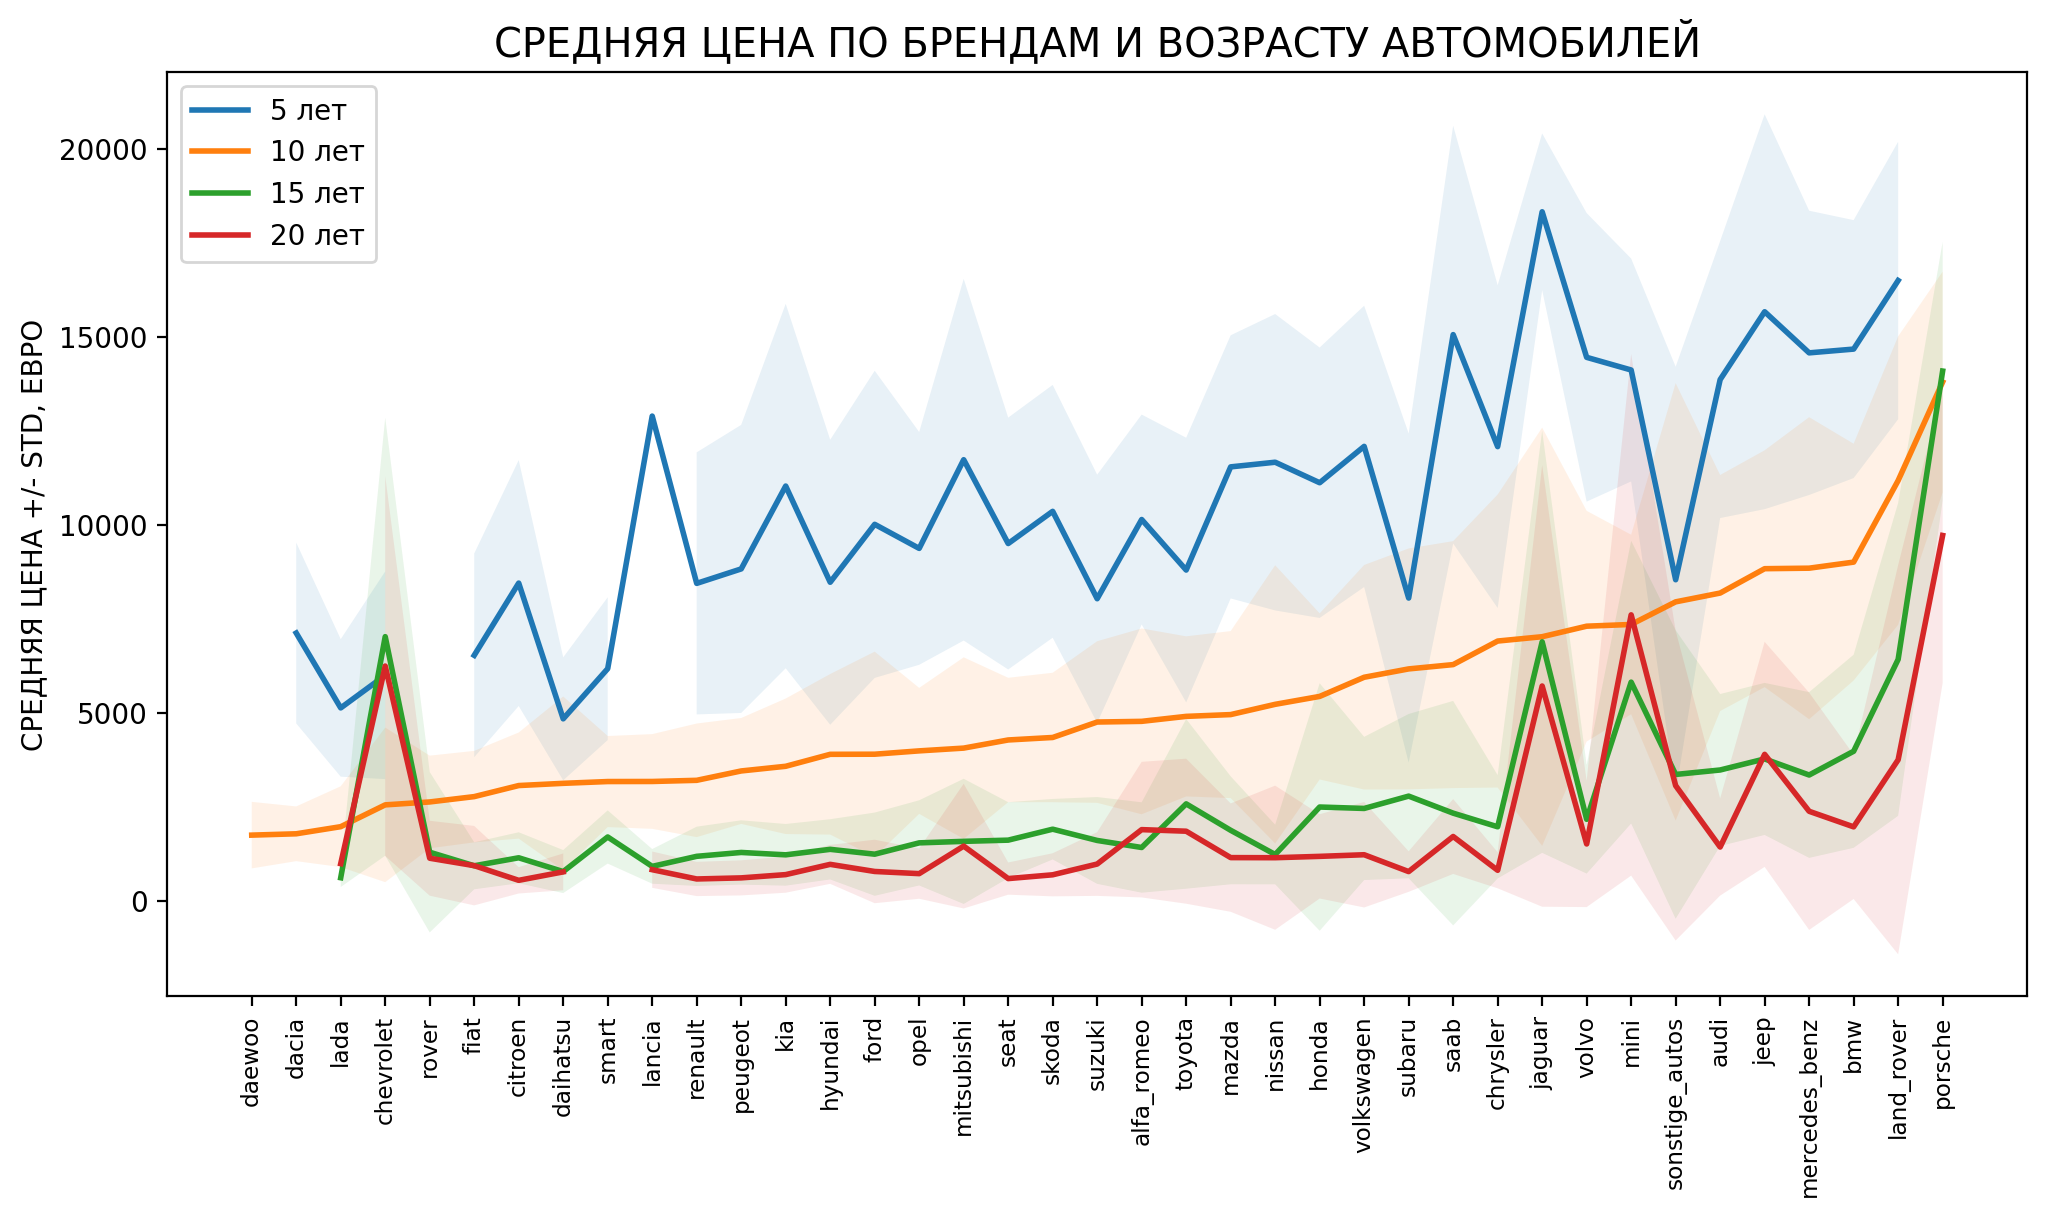

In [62]:
ages = [5, 10, 15, 20]
prices = df.loc[df.CarAge.isin(ages),
                ['CarAge', 'Brand', 'Price']].pivot_table(
                    index='Brand',
                    values='Price',
                    columns='CarAge',
                    aggfunc=['mean', 'std']).sort_values(by=('mean', 10))
fig = plt.figure(figsize=(12, 6))
for age in ages:
    plt.plot(prices.index,
             prices[('mean', age)],
             lw=2,
             label=f"{age} {'год' if age == 1 else 'лет'}")
    plt.fill_between(prices.index,
                     prices[('mean', age)] - prices[('std', age)],
                     prices[('mean', age)] + prices[('std', age)],
                     alpha=.1)
    plt.legend(loc='upper left')
    plt.xticks(rotation=90, fontsize='small')
    plt.title('Средняя цена по брендам и возрасту автомобилей'.upper(),
              fontsize='x-large')
    plt.ylabel('Средняя цена +/- std, евро'.upper())
plt.show()

Здесь мы видим, влияние бренда на цену для возраста 5, 10 и 15 лет: слева дешевые, справа дорогие автомобили и цена растет слева направо. При этом в зависимости от возраста порядок брендов может меняться: если для 10-летних автомобилей мы видим монотонно возрастающий график, то для других возрастов графики колеблются.  

Для автомобилей с возрастом 1 год и 25 лет мы видим прерывистые графики: таких автомобилей уже меньше и не все бренды представлены. Примечательно, что для 1-летних авто лучше представлены бренды среднего ценового диапазона, а для 25-летних — более дорогие бренды. 

Обратим внимание, что для 1-летних дорогих брендов график цены находится ниже, чем для брендов средней ценовой категории, и сильно колеблется. 

#### Выводы

В результате исслеодовательского анализа данных мы изучили структуру данных, проанализировали пропуски и аномальные значения. 

Исследование позволило нам сделать следующее.

1. Обнаружить дубликаты и незначимые признаки.
1. Убедиться, что в данных нет ошибок заполнения.
1. Заменить признаки с типом дата-время `DateCreated`, `DateCrawled` целочисленным признаком `AnketaAge`, а также заменить три признака `DateCreated`, `RegistrationYear` и `RegistrationMonth` одним целочисленным признаком `CarAge`. 
1. Выяснить, что наибольшее количество объявлений имеет возраст автомобиля от 5 до 20 лет. 
1. Убедиться, что в датасете есть аномальные значения возраста автомобиля и мощности двигателя. На сайте [https://www.autoscout24.de](https://www.autoscout24.de) мы видим примеры объявлений с некорректными значениями вроде [микроавтобуса Пежо можностью 10 000 лошадиных сил](https://www.autoscout24.com/offers/peugeot-partner-premium-100-pk-650-kg-staat-in-bestelling-diesel-black-945154e4-b101-4346-a4d9-64c4eeb76db1?sort=power&desc=1&lastSeenGuidPresent=false&cldtidx=2&position=2&search_id=gnia8z6qkx&source_otp=t10&source=listpage_search-results), или [Ягуаром XF, зарегистрированным в 1900 году](https://www.autoscout24.com/offers/jaguar-xf-3-0-v6-luxury-aut-gasoline-black-d664dfaa-e2e5-153c-e053-0100007f683b?sort=standard&desc=0&lastSeenGuidPresent=false&cldtidx=4&position=4&search_id=1twmmj4jg4&source_otp=t10&source=listpage_search-results).
1. На сайте [https://www.autoscout24.de](https://www.autoscout24.de) мы также увидели, что кроме автомобилей в объявлениях могут встречаться запчасти, для которых нормальным является пропуск значений с характеристиками автомобиля вроде типа кузова или типа трансмиссии.

У нас нет сведений об источнике данных, но сравнение значений и типов данных нашего датасета с объявлениями на  [autoscout24.de](https://www.autoscout24.de) позволяет объяснить природу аномальных значений и пропусков и выбрать методы устранения аномалий и пропусков.


### Устранение аномалий и пропусков

На этапе исследовательского анализа данных мы выявили проблемы в датасете. Применем следующие методы для устранения аномалий и пропусков:

1. Наличие дубликатов — удалим.
1. Пропуски в целевом признаке `Price`, 3% объектов — удалим.
1. Строковый тип у признаков `DateCreated` и `DateCrowled` — заменим на DateTime
1. Нулевые значения в признаке `RegistrationMonth` — заменим признаки `DateCreated`, `RegistrationYear` и `RegistrationMonth` одним целочисленным признаком 
$\mathit{CarAge} = \mathit{round}((\mathit{RegistrationYear} \times 12 + \mathit{RegistrationMonth} - \mathit{year}(\mathit{DateCreated}) \times 12 -  \mathit{month}(\mathit{DateCreated})) / 12)$.
1. Пропуски `Model`, `Gearbox`, `VehicleType`, `FuelType`, `NotRepaired` заполним значением `other` — мы видим, что эти признаки содержат такое значение. На примере [autoscout24.de](https://www.autoscout24.de ) видим, что среди объявлений могут быть не автомобили, а отдельные детали и для них значения характеристик автомобиля пропускаются либо имеют значение other.
1. Отрицательные значения возраста автомобиля `CarAge` заменим на 0
1. Значения возраста автомобиля `CarAge` больше 40 лет заменим на 40
1. Значения мощности более 500 удалим, после чего заполним пропуски средним значением мощности для марки и модели в объявлении. Если среднее значение посчитать не сможем, укажем 0
1. Добавим расчетный признак $\mathit{AnketaAge} = \mathit{DateCrawled} - \mathit{DateCreated} $



Для выполнения этих действий мы определили функции, а также класс CarPower с методами fit и transform.

In [63]:
del(df)

Сохраним шаги по очистке данных в списке.

In [64]:
steps = [
    convert_str_to_datetime, remove_duplicates, remove_empty_price_rows,
    add_car_age_feature, add_anketa_age_feature, fill_na_with_other,
    replace_negative_age, replace_age_over_40
]

In [65]:
steps = [
    convert_str_to_datetime, remove_duplicates, filter_price,
    add_car_age_feature, add_anketa_age_feature, fill_na_with_other,
    replace_negative_age, filter_age
]

In [66]:
train_data = X_train.join(y_train)
clean_df = clear_data(train_data.copy(), steps)
clean_df.shape

(212801, 18)

In [67]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212801 entries, 0 to 279201
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        212801 non-null  datetime64[ns]
 1   VehicleType        212801 non-null  object        
 2   RegistrationYear   212801 non-null  int64         
 3   Gearbox            212801 non-null  object        
 4   Power              212801 non-null  int64         
 5   Model              212801 non-null  object        
 6   Kilometer          212801 non-null  int64         
 7   RegistrationMonth  212801 non-null  int64         
 8   FuelType           212801 non-null  object        
 9   Brand              212801 non-null  object        
 10  NotRepaired        212801 non-null  object        
 11  DateCreated        212801 non-null  datetime64[ns]
 12  NumberOfPictures   212801 non-null  int64         
 13  PostalCode         212801 non-null  int64   

Сохраним часть данных без обработки аномальных значений для проверки качества очистки данных.

In [68]:
loose_cleaned_data = clear_data(
    train_data.sample(frac=.2, random_state=RANDOM_STATE),
    [convert_str_to_datetime, remove_duplicates, remove_empty_price_rows])

loose_cleaned_data = loose_cleaned_data.fillna('unknown')

del(train_data)

Рассчитаем средние значения мощности двигателей для марок и моделей автомобилей.

In [69]:
cars_power = CarPower()
cars_power.fit(clean_df)

In [70]:
clean_df = cars_power.transform(clean_df)

В качестве признаков возьмем:
- численные: AnketaAge, CarAge, Power, Kilometer, PostalCode
- категориальные: 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'

In [71]:
numerical_features = ['AnketaAge', 'CarAge', 'Power', 'Kilometer', 'PostalCode']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [72]:
clean_df[numerical_features].describe()

,AnketaAge,CarAge,Power,Kilometer,PostalCode
count,212801.000000,212801.000000,212801.000000,212801.000000,212801.000000
mean,0.855057,12.295995,113.949608,130830.846660,51095.815602
std,2.344462,4.318262,61.549742,33564.862381,25562.244990
min,0.000000,4.000000,0.000000,5000.000000,1067.000000
25%,1.000000,9.000000,75.000000,125000.000000,30938.000000
50%,1.000000,12.000000,109.000000,150000.000000,50169.000000
75%,1.000000,16.000000,150.000000,150000.000000,71384.000000
max,737.000000,20.000000,500.000000,150000.000000,99998.000000


In [73]:
clean_df[categorical_features].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,212801,212801,212801,212801,212801,212801
unique,9,3,246,8,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,58897,161968,15767,128509,43663,160608


Подготовим обучающую и тестовые выборки.

In [74]:
X_train = clean_df[categorical_features+numerical_features]
y_train = clean_df.Price

In [75]:
del(clean_df)

In [76]:
X_train.shape, y_train.shape

((212801, 11), (212801,))

In [77]:
clean_test_df = clear_data(X_test.join(y_test), steps)
clean_test_df.shape

(53853, 18)

In [78]:
clean_test_df = cars_power.transform(clean_test_df)

In [79]:
X_test = clean_test_df[categorical_features+numerical_features]
y_test = clean_test_df.Price

In [80]:
X_test.shape, y_test.shape

((53853, 11), (53853,))

### Выводы

- Удалить объекты с пропуском `Price`
- Удалить признак `NumberOfPictures`, `LastSeen`
- расчет `AnketaAge` и `CarAge`
- Ограничим область применения нашей модели возрастом автомобиля от >0 и <40 лет.
- Мощность не более 500 лс
- Цена от 100 долларов

## Обучение моделей

На этапе анализа времени нам не понадобится наилучшая точность, поэтому возьмем 20% нашей обучающей выборки для повышения скорости работы моделей.

In [81]:
sample = X_train.join(y_train).sample(frac=.2, random_state=RANDOM_STATE)
X_sample = sample.drop('Price', axis=1)
y_sample = sample.Price
del(sample)

Для оценки результатов будем использовать кросс-валидацию методом RepeatedKFold.

In [82]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

Замерим базовые значения RMSE для линейной регресии и Dummy-модели, возрвращающей в качестве прогноза среднее значение целевого признака.

In [83]:
column_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [84]:
pipeline_lr = make_pipeline(column_transformer, LinearRegression(n_jobs=-1))
pipeline_dm = make_pipeline(column_transformer, DummyRegressor())

In [85]:
%%time
for est, name in zip([pipeline_lr, pipeline_dm], ['Linear Regression', 'Dummy Regression']): 
    print(name)
    cross_validate_model(est, X_sample, y_sample)

Linear Regression
fit time	 0.83s +/- 0.09s
score time	 0.04s +/- 0.00s
RMSE		 2110 +/- -20
R2 		 0.768 +/- 0.005

Dummy Regression
fit time	 0.12s +/- 0.02s
score time	 0.04s +/- 0.01s
RMSE		 4385 +/- -21
R2 		 -0.000 +/- 0.000

CPU times: user 517 ms, sys: 196 ms, total: 713 ms
Wall time: 4.48 s


Мы видим, что линейная регрессия дает результаты почти в два раза лучше случайной модели. Значит наша модель состоятельна.

### Проверка очистки данных

В процессе очистки данных мы преобразовали признаки и ограничили значения  мощности и возраста автомобилей. Также мы заменили пропуски категориальных признаков значением 'unknown'. Сравним результаты обучения моделей на очищенных данных с результатами на данных без очистки при замене пропусков на 'unknown'и на 'other'.

In [86]:
loose_cleaned_data_columns_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), [
         'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
         'PostalCode'
     ])],
    remainder='drop')
loose_cleaned_data_pipeline = make_pipeline(
    loose_cleaned_data_columns_transformer, LinearRegression(n_jobs=-1))

In [87]:
print('Cleaned dataset')
cross_validate_model(pipeline_lr, X_sample, y_sample)

print('Dataset without cleaning')
cross_validate_model(loose_cleaned_data_pipeline,
                     loose_cleaned_data.drop('Price', axis=1),
                     loose_cleaned_data.Price)

print()

Cleaned dataset
fit time	 0.75s +/- 0.06s
score time	 0.04s +/- 0.01s
RMSE		 2110 +/- -19
R2 		 0.768 +/- 0.004

Dataset without cleaning
fit time	 0.96s +/- 0.04s
score time	 0.04s +/- 0.00s
RMSE		 3131 +/- -28
R2 		 0.523 +/- 0.005




Очистка признаков дала результаты.

### Выбор признаков

Последовательно удалим из признаков по одному и оценим качетсво модели без каждого признака.

In [88]:
removed_columns, scores = [], []

for column in numerical_features:
    reduced_numerical_features = numerical_features.copy()
    reduced_numerical_features.remove(column)

    removed_columns.append(column)
    scores.append(
        get_cv_result(X_sample, y_sample, reduced_numerical_features,
                      categorical_features, cv))

    print(column, reduced_numerical_features, f'{scores[-1]:.3f}')

    
for column in categorical_features:
    reduced_categorical_features = categorical_features.copy()
    reduced_categorical_features.remove(column)

    removed_columns.append(column)
    scores.append(
        get_cv_result(X_sample, y_sample, numerical_features,
                      reduced_categorical_features, cv))
    
    print(column, reduced_categorical_features, f'{scores[-1]:.3f}')

    
features_impact = pd.DataFrame({'removed_column': removed_columns, 'rmse': scores})    

AnketaAge ['CarAge', 'Power', 'Kilometer', 'PostalCode'] 0.768
CarAge ['AnketaAge', 'Power', 'Kilometer', 'PostalCode'] 0.590
Power ['AnketaAge', 'CarAge', 'Kilometer', 'PostalCode'] 0.746
Kilometer ['AnketaAge', 'CarAge', 'Power', 'PostalCode'] 0.753
PostalCode ['AnketaAge', 'CarAge', 'Power', 'Kilometer'] 0.768
VehicleType ['Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'] 0.761
Gearbox ['VehicleType', 'Model', 'FuelType', 'Brand', 'NotRepaired'] 0.765
Model ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired'] 0.740
FuelType ['VehicleType', 'Gearbox', 'Model', 'Brand', 'NotRepaired'] 0.768
Brand ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'] 0.762
NotRepaired ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'] 0.762


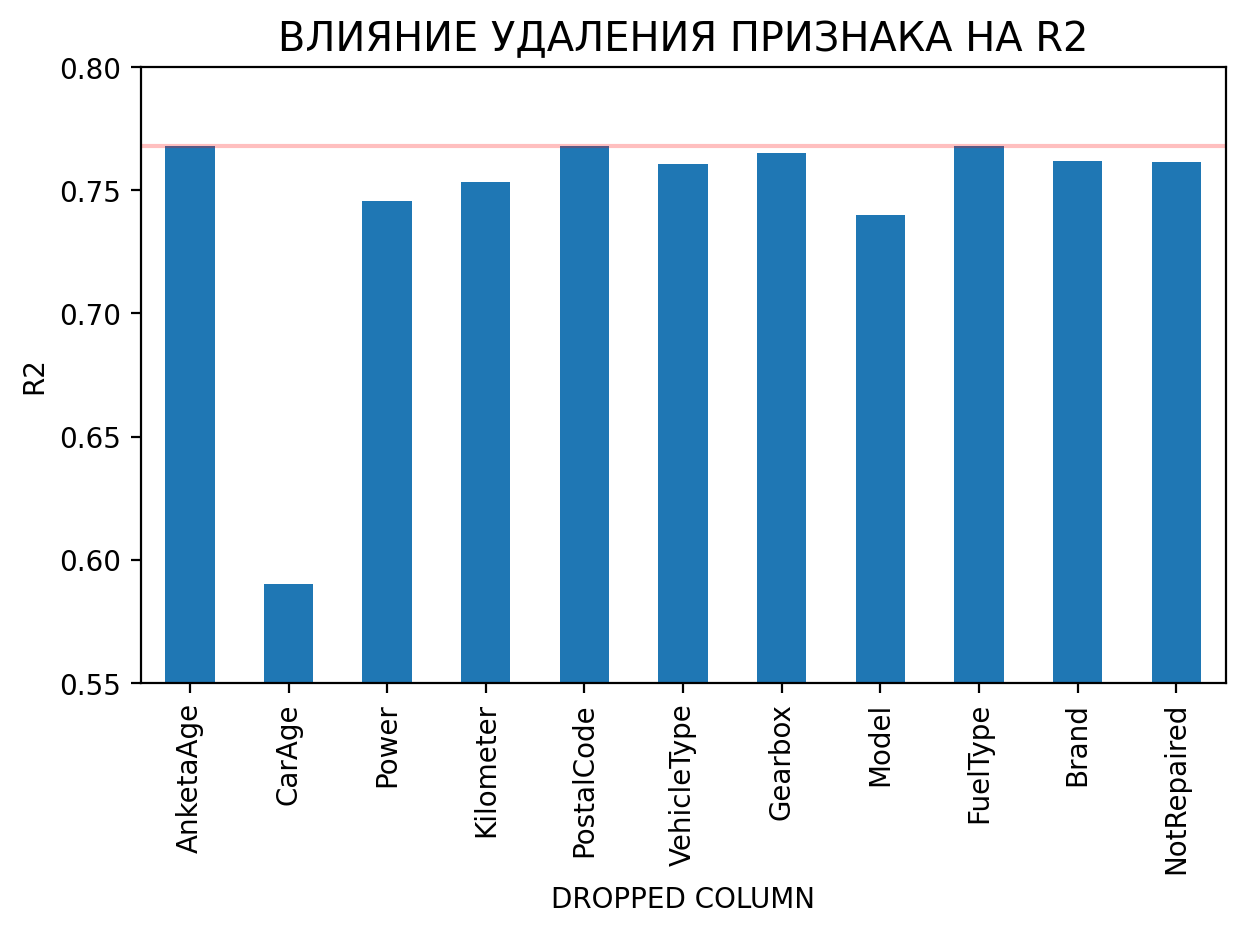

In [89]:
ax = features_impact.plot.bar(xticks=features_impact.index,
                              rot=90,
                              figsize=(7, 4),
                              legend=None)
ax.set_xticklabels(features_impact.removed_column)
plt.axhline(.768, c='r', alpha=.25)
plt.title('Влияние удаления признака на R2'.upper(), fontsize='x-large')
plt.xlabel('Dropped column'.upper())
plt.ylabel('R2'.upper())
plt.ylim(.55, .8)
plt.show()

Мы видим, что удаление `AnketaAge` и `PostalCode` не сказываются на результатах модели. Больше всего влияет возраст автомобиля, пробег и модель — логично.

In [90]:
numerical_features.remove('AnketaAge')
numerical_features.remove('PostalCode')

numerical_features

['CarAge', 'Power', 'Kilometer']

In [91]:
categorical_features.remove('FuelType')
categorical_features.remove('Gearbox')

categorical_features

['VehicleType', 'Model', 'Brand', 'NotRepaired']

### Выбор моделей

In [92]:
ohe_sparse_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [93]:
ohe_dense_transformer = ColumnTransformer(
    [('categorical',
      OneHotEncoder(dtype='int', handle_unknown='ignore',
                    sparse=False), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [94]:
ordinal_transformer = ColumnTransformer(
    [('categorical',
      OrdinalEncoder(handle_unknown="use_encoded_value",
                     unknown_value=np.nan), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [95]:
categorical_mask = [True] * len(categorical_features) + [False] * len(
    numerical_features)
fit_params = {
    'lgbmregressor__categorical_feature':
    [_ for _ in range(len(categorical_features))]
}

In [96]:
baseline_estimators = [
    make_pipeline(ohe_sparse_transformer, LinearRegression(n_jobs=-1)),
    make_pipeline(
        ohe_sparse_transformer,
        DecisionTreeRegressor(min_samples_leaf=100, random_state=RANDOM_STATE)),
    make_pipeline(
        ohe_dense_transformer,
        HistGradientBoostingRegressor(min_samples_leaf=31,
                                      random_state=RANDOM_STATE)),
    make_pipeline(
        ordinal_transformer,
        HistGradientBoostingRegressor(min_samples_leaf=31,
                                      categorical_features=categorical_mask,
                                      random_state=RANDOM_STATE)),
    make_pipeline(ohe_sparse_transformer,
                  LGBMRegressor(random_state=RANDOM_STATE)),
    make_pipeline(ordinal_transformer,
                  LGBMRegressor(random_state=RANDOM_STATE)),
]

In [97]:
scores = dict()
for est, name in zip(baseline_estimators, [
        'LinearRegression', 'DecisionTreeRegressor',
        'HistGradientBoostingRegressor',
        'HistGradientBoostingRegressor w categorical', 'LGBMRegressor',
        'LGBMRegressor w categorical'
]):
    print(name)
    params = fit_params if name == 'LGBMRegressor w categorical' else dict()
    scores[name] = cross_validate_model(est,
                                        X_sample,
                                        y_sample,
                                        fit_params=params)

LinearRegression
fit time	 0.51s +/- 0.05s
score time	 0.03s +/- 0.01s
RMSE		 2125 +/- -25
R2 		 0.765 +/- 0.005

DecisionTreeRegressor
fit time	 0.47s +/- 0.02s
score time	 0.03s +/- 0.01s
RMSE		 2054 +/- -28
R2 		 0.781 +/- 0.006

HistGradientBoostingRegressor
fit time	 11.42s +/- 0.98s
score time	 0.46s +/- 0.03s
RMSE		 1610 +/- -31
R2 		 0.865 +/- 0.005

HistGradientBoostingRegressor w categorical
fit time	 1.27s +/- 0.09s
score time	 0.22s +/- 0.01s
RMSE		 1560 +/- -23
R2 		 0.873 +/- 0.003

LGBMRegressor
fit time	 0.50s +/- 0.03s
score time	 0.16s +/- 0.01s
RMSE		 1596 +/- -26
R2 		 0.867 +/- 0.003

LGBMRegressor w categorical


/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/yp13-gradient-boosting/venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using

fit time	 0.45s +/- 0.02s
score time	 0.13s +/- 0.01s
RMSE		 1553 +/- -24
R2 		 0.875 +/- 0.004



### Подбор гиперпараметров

Подготовим данные с закодированными категориальными признаками и масштабированными числовыми.

In [98]:
X_sample = pd.DataFrame(ordinal_transformer.fit_transform(X_sample),
                        columns=categorical_features + numerical_features)

for column in categorical_features:
    X_sample[column] = pd.Categorical(X_sample[column])
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42560 entries, 0 to 42559
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   VehicleType  42560 non-null  category
 1   Model        42560 non-null  category
 2   Brand        42560 non-null  category
 3   NotRepaired  42560 non-null  category
 4   CarAge       42560 non-null  float64 
 5   Power        42560 non-null  float64 
 6   Kilometer    42560 non-null  float64 
dtypes: category(4), float64(3)
memory usage: 1.2 MB


In [99]:
X_sample.head()

,VehicleType,Model,Brand,NotRepaired,CarAge,Power,Kilometer
0,1.0,237.0,2.0,0.0,-0.987378,1.669913,-0.909044
1,4.0,28.0,1.0,0.0,1.315343,0.815855,0.574216
2,2.0,190.0,38.0,0.0,-1.217650,0.122940,-2.095651
3,8.0,223.0,24.0,0.0,1.315343,-1.843006,0.574216
4,5.0,74.0,21.0,0.0,-1.447922,0.960884,-1.798999


In [100]:
dt_param_distributions = {
    'max_depth': np.arange(100, 600, 100),
    'min_samples_split': [2**i for i in range(4, 11)],
    'min_samples_leaf': [2**i for i in range(3, 9)]
}

In [101]:
dt_search_estimator = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_distributions=dt_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

In [102]:
%%time
if path.isfile('data/dt_search_results.pkl'):
    dt_search_results = load_object('data/dt_search_results.pkl')
else:
    dt_search_results = dt_search_estimator.fit(X_sample, y_sample)
    save_object('data/dt_search_results.pkl', dt_search_results)

CPU times: user 1.49 ms, sys: 1.3 ms, total: 2.79 ms
Wall time: 2.4 ms


In [105]:
lgbm_param_distributions = {
    'n_estimators': np.arange(200, 1600, 100),
    'num_leaves': [2**i for i in range(3, 9)],
    'learning_rate': np.logspace(-2, 1, num=20, endpoint=True, base=10, dtype=float, axis=0),
    'subsample': [0.3, 0.5, 0.7, 0.9, 1],
    'subsample_freq': [5, 25, 625],
    'min_child_samples': np.arange(25, 275, 25),
    'reg_lambda': np.append([0],
                    np.logspace(0,
                                3,
                                num=20,
                                endpoint=True,
                                base=10,
                                dtype=float,
                                axis=0)),
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1]
}

In [106]:
lgbm_search_estimator = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=RANDOM_STATE),
    param_distributions=lgbm_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

In [107]:
%%time
if path.isfile('data/lgbm_search_results.pkl'):
    lgbm_search_results = load_object('data/lgbm_search_results.pkl')
else:
    lgbm_search_results = lgbm_search_estimator.fit(X_sample, y_sample)
    save_object('data/lgbm_search_results.pkl', lgbm_search_results)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
CPU times: user 7.67 s, sys: 1.26 s, total: 8.93 s
Wall time: 52min 1s


In [108]:
hgbr_param_distributions = {
    'max_iter': np.arange(100, 1600, 100),
    'max_leaf_nodes': [2**i for i in range(1, 9)],
    'learning_rate': np.logspace(-2, 1, num=20, endpoint=True, base=10, dtype=float, axis=0),
    'min_samples_leaf': np.arange(25, 275, 25),
    'l2_regularization': np.append([0],
                    np.logspace(0,
                                3,
                                num=20,
                                endpoint=True,
                                base=10,
                                dtype=float,
                                axis=0))
}

In [109]:
hgbr_search_estimator = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(
        categorical_features=categorical_mask, random_state=RANDOM_STATE),
    param_distributions=hgbr_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True)

In [110]:
%%time
if path.isfile('data/hgbr_search_results.pkl'):
    hgbr_search_results = load_object('data/hgbr_search_results.pkl')
else:
    hgbr_search_results = hgbr_search_estimator.fit(X_sample, y_sample)
    save_object('data/hgbr_search_results.pkl', hgbr_search_results)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
CPU times: user 6.66 s, sys: 938 ms, total: 7.6 s
Wall time: 22min 53s


In [111]:
results_columns = [
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score',
    'params', 'rank_test_score'
]

In [112]:
dt_results = pd.DataFrame(
    dt_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1900').sort_values(by="mean_test_score")


lgbm_results = pd.DataFrame(
    lgbm_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1600 and mean_train_score < -1300').sort_values(by="mean_test_score")


hgbr_results = pd.DataFrame(
    hgbr_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1600 and mean_train_score < -1300').sort_values(by="mean_test_score")

In [113]:
def plot_searh_curve(df: pd.DataFrame, ax: plt.axes, model_name: str) -> None:
    ax.set_title(model_name.upper())
    ax.set_ylabel("RMSE")
    ax.set_xlabel("experiment number")
    x_range = range(df.shape[0])
    ax.grid(True)

    ax.plot(x_range,
            df.mean_train_score,
            'r-',
            lw=3,
            marker='o',
            markersize=9,
            label='train mean')
    ax.fill_between(x_range,
                    df.mean_train_score - df.std_train_score,
                    df.mean_train_score + df.std_train_score,
                    alpha=0.2,
                    color='red',
                    label='train std')

    ax.plot(x_range,
            df.mean_test_score,
            'g-',
            lw=3,
            marker='o',
            markersize=9,
            label='valid mean')
    ax.fill_between(x_range,
                    df.mean_test_score - df.std_test_score,
                    df.mean_test_score + df.std_test_score,
                    alpha=0.2,
                    color='green',
                    label='valid std')
    ax.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(x_range, df.mean_fit_time, lw=3, alpha=.5, label='fit time')
    ax2.plot(x_range, df.mean_score_time, lw=3, alpha=.5, label='score time')
    ax2.set_ylabel('time, s')
    ax2.legend(loc='upper right')

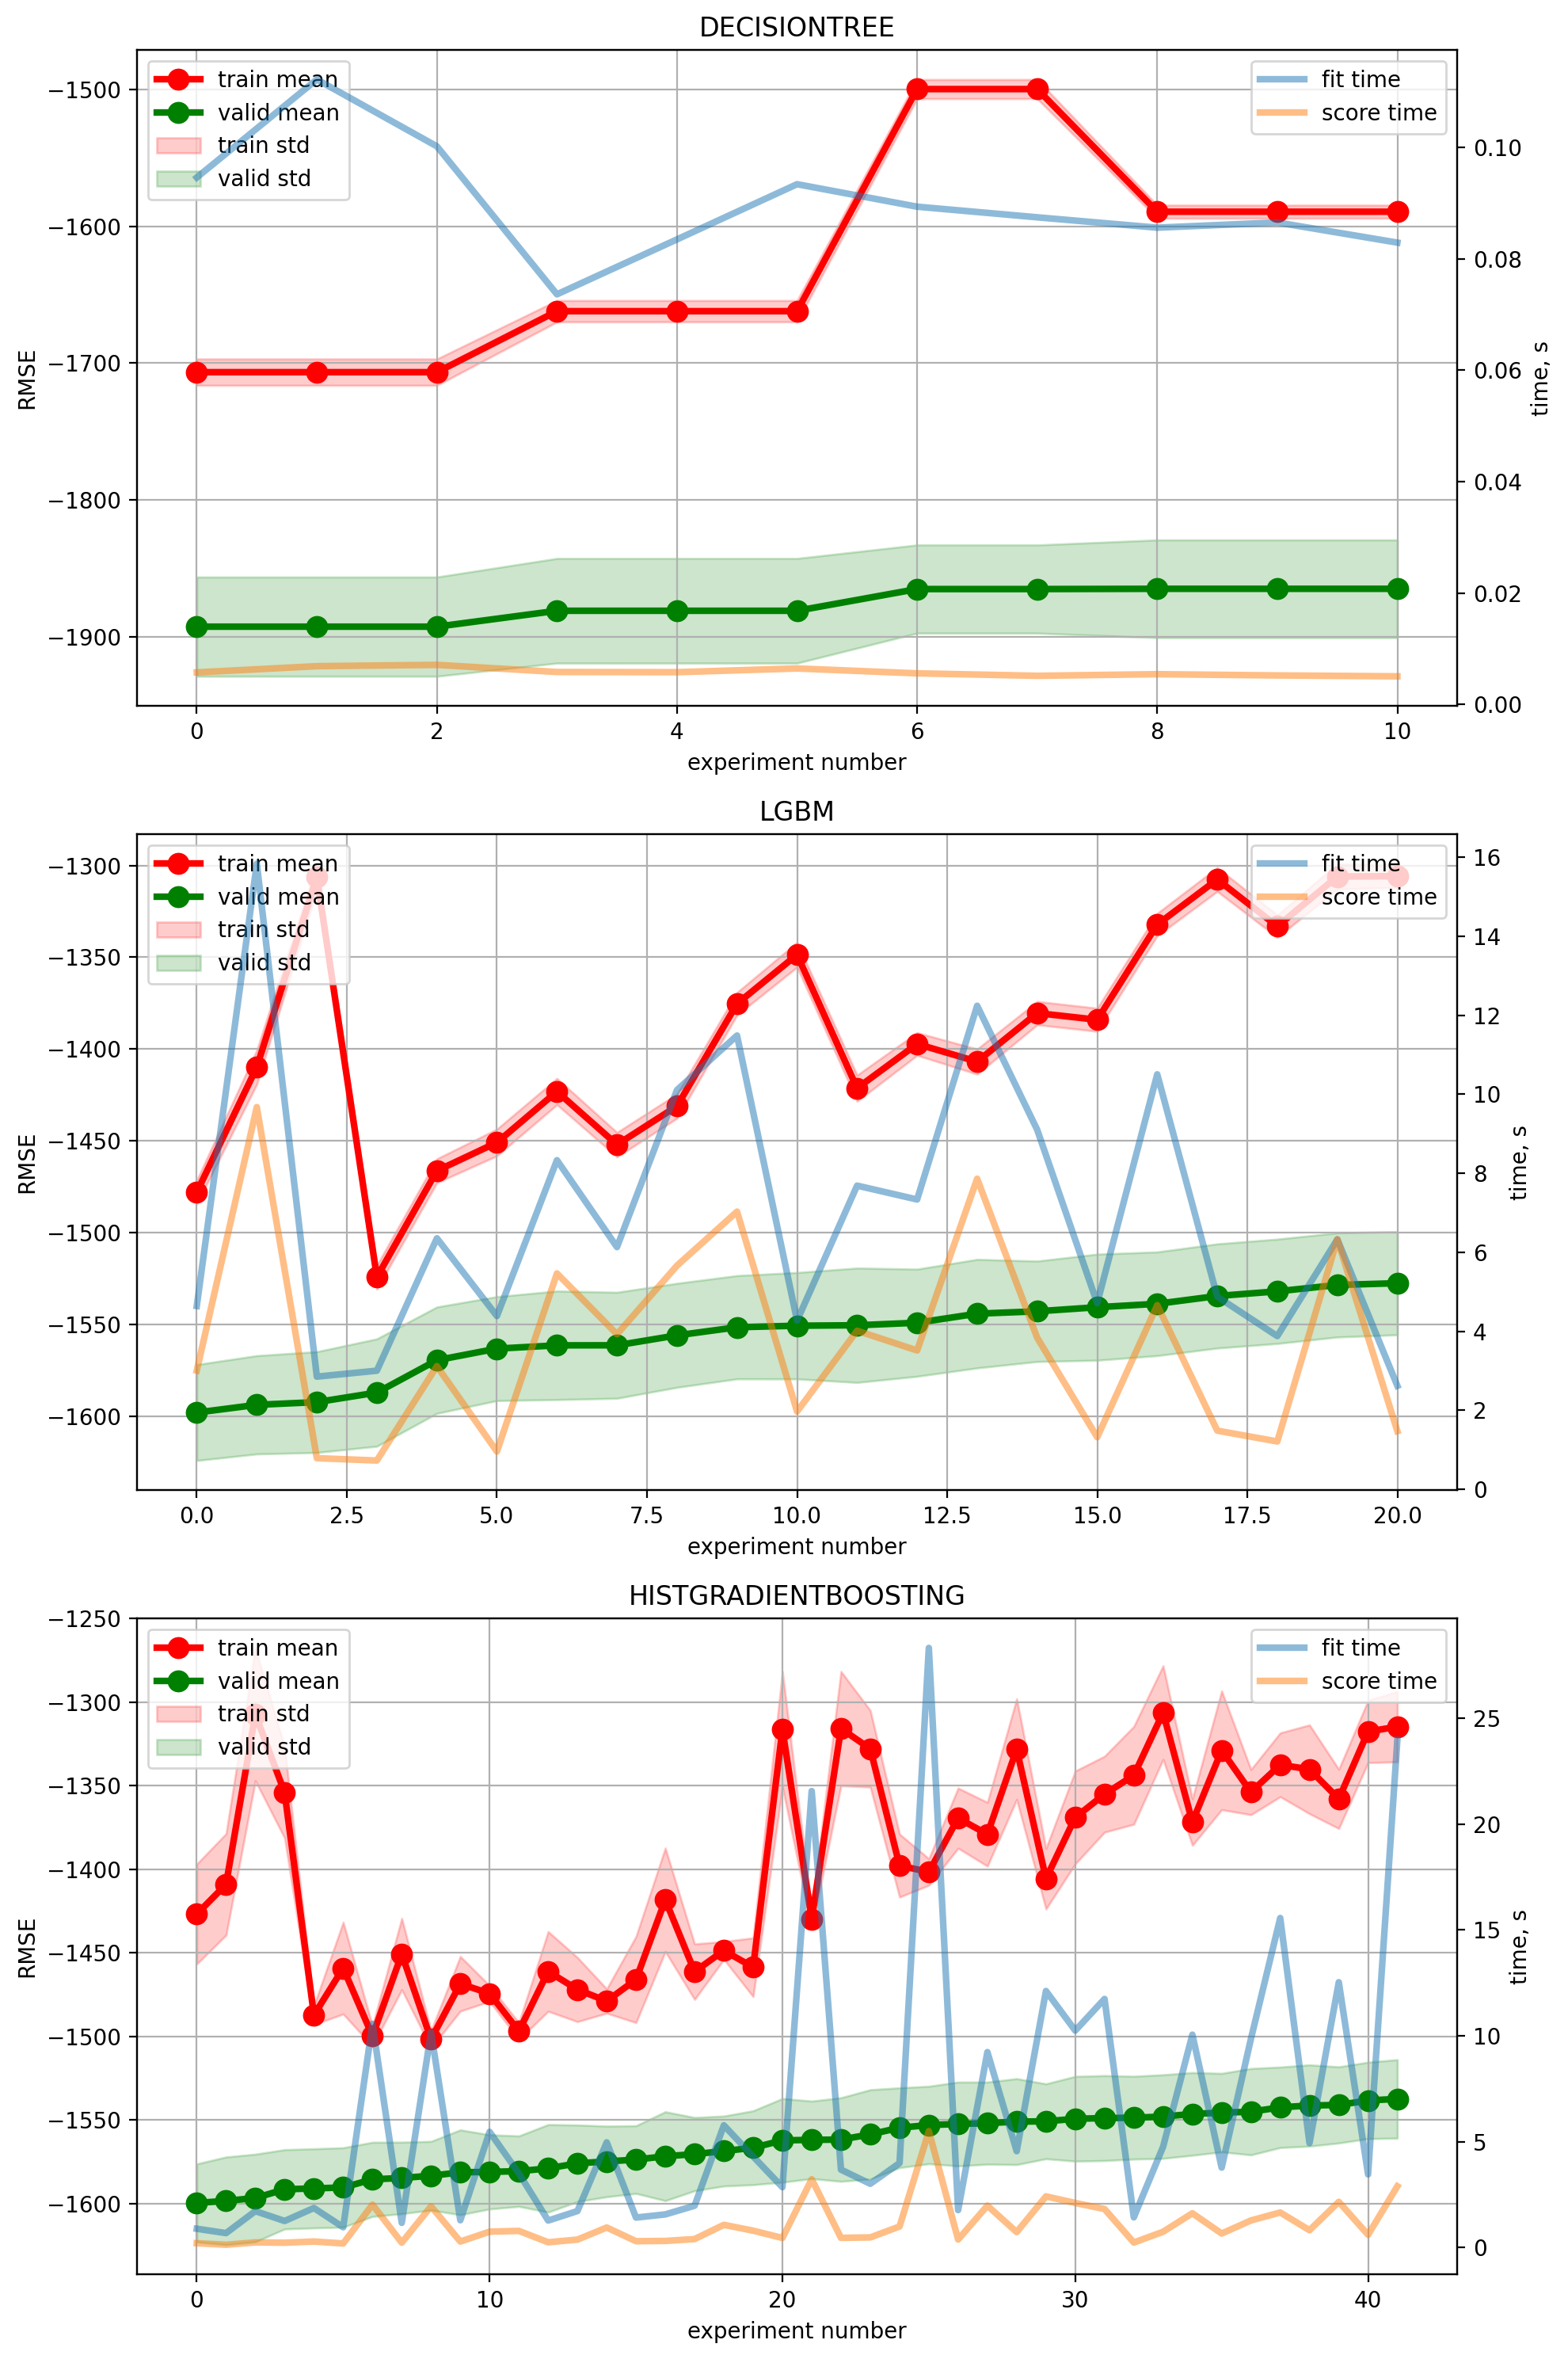

In [114]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_searh_curve(dt_results, ax=axes[0], model_name='DecisionTree')
plot_searh_curve(lgbm_results, ax=axes[1], model_name='LGBM')
plot_searh_curve(hgbr_results, ax=axes[2], model_name='HistGradientBoosting')
plt.tight_layout()
plt.show()

In [128]:
dt_best_idx = -1
lgbm_best_idx = -3
hgbr_best_idx = -3

In [129]:
_cols = hgbr_results.columns.to_list()
_cols.remove('params')
_cols.remove('rank_test_score')

dt_best_params = dt_results.iloc[[dt_best_idx]].params.values[0]
lgbm_best_params = lgbm_results.iloc[[lgbm_best_idx]].params.values[0]
hgbr_best_params = hgbr_results.iloc[[hgbr_best_idx]].params.values[0]

comparison = pd.concat([
    dt_results.iloc[[dt_best_idx]], lgbm_results.iloc[[lgbm_best_idx]],
    hgbr_results.iloc[[hgbr_best_idx]]
])[_cols].T
comparison.columns = ['DecisionTree', 'LGBM', 'HistGradientBoosting']

comparison

,DecisionTree,LGBM,HistGradientBoosting
mean_fit_time,0.082887,3.880163,12.527789
std_fit_time,0.004377,0.312580,1.838662
mean_score_time,0.005073,1.213166,2.152231
std_score_time,0.000575,0.308353,0.458140
mean_test_score,-1865.033590,-1532.038328,-1540.901312
std_test_score,35.735240,28.458750,22.792162
mean_train_score,-1589.379037,-1333.072792,-1357.927589
std_train_score,4.806636,6.098752,17.710890


In [130]:
(dt_best_params, lgbm_best_params, hgbr_best_params)

({'min_samples_split': 32, 'min_samples_leaf': 8, 'max_depth': 100},
 {'subsample_freq': 5,
  'subsample': 0.7,
  'reg_lambda': 78.47599703514611,
  'num_leaves': 128,
  'n_estimators': 300,
  'min_child_samples': 50,
  'learning_rate': 0.06158482110660264,
  'colsample_bytree': 0.8},
 {'min_samples_leaf': 100,
  'max_leaf_nodes': 64,
  'max_iter': 800,
  'learning_rate': 0.0206913808111479,
  'l2_regularization': 8.858667904100825})

```
({'min_samples_split': 32, 'min_samples_leaf': 8, 'max_depth': 100},
 {'subsample_freq': 625,
  'subsample': 1,
  'reg_lambda': 10.0,
  'num_leaves': 256,
  'n_estimators': 800,
  'min_child_samples': 100,
  'learning_rate': 0.01438449888287663,
  'colsample_bytree': 0.6},
 {'min_samples_leaf': 75,
  'max_leaf_nodes': 64,
  'max_iter': 400,
  'learning_rate': 0.07847599703514611,
  'l2_regularization': 0.18329807108324356})
```

### Обучение моделей

In [ ]:
ordinal_transformer.fit(X_train)

X_train = pd.DataFrame(ordinal_transformer.transform(X_train),
                        columns=categorical_features + numerical_features)
X_test = pd.DataFrame(ordinal_transformer.transform(X_test),
                        columns=categorical_features + numerical_features)

for column in categorical_features:
    X_train[column] = pd.Categorical(X_train[column])
    X_test[column] = pd.Categorical(X_test[column])

In [133]:
X_train.shape, X_sample.shape

((212801, 7), (42560, 7))

In [139]:
lgbm_model = LGBMRegressor(**lgbm_best_params, random_state=RANDOM_STATE)

In [140]:
%%time
lgbm_model.fit(X_train, y_train)

CPU times: user 23.2 s, sys: 293 ms, total: 23.5 s
Wall time: 3.16 s


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.06158482110660264,
              min_child_samples=50, n_estimators=300, num_leaves=128,
              random_state=RandomState(MT19937) at 0x7FDD29D9A740,
              reg_lambda=78.47599703514611, subsample=0.7, subsample_freq=5)

In [141]:
hgbr_model = HistGradientBoostingRegressor(**hgbr_best_params,
        categorical_features=categorical_mask, random_state=RANDOM_STATE)

In [142]:
%%time
hgbr_model.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 5.42 s, total: 2min 31s
Wall time: 20.2 s


HistGradientBoostingRegressor(categorical_features=[True, True, True, True,
                                                    False, False, False],
                              l2_regularization=8.858667904100825,
                              learning_rate=0.0206913808111479, max_iter=800,
                              max_leaf_nodes=64, min_samples_leaf=100,
                              random_state=RandomState(MT19937) at 0x7FDD29D9A740)

In [148]:
%%time
lgbm_train_predictions = lgbm_model.predict(X_train)

CPU times: user 13.1 s, sys: 40.2 ms, total: 13.1 s
Wall time: 1.81 s


In [149]:
%%time
hgbr_train_predictions = hgbr_model.predict(X_train)

CPU times: user 43.4 s, sys: 240 ms, total: 43.7 s
Wall time: 5.63 s


In [150]:
lgbm_train_rmse = mean_squared_error(y_train, lgbm_train_predictions, squared=False)
lgbm_train_rmse

1356.9893750407764

In [151]:
hgbr_train_rmse = mean_squared_error(y_train, hgbr_train_predictions, squared=False)
hgbr_train_rmse

1381.999863051736

## Анализ моделей

In [152]:
%%time
lgbm_test_predictions = lgbm_model.predict(X_test)

CPU times: user 3.42 s, sys: 16.6 ms, total: 3.43 s
Wall time: 505 ms


In [153]:
%%time
hgbr_test_predictions = hgbr_model.predict(X_test)

CPU times: user 11.4 s, sys: 107 ms, total: 11.5 s
Wall time: 1.53 s


In [154]:
lgbm_test_rmse = mean_squared_error(y_test, lgbm_test_predictions, squared=False)
lgbm_test_rmse

1418.3651520615927

In [155]:
hgbr_test_rmse = mean_squared_error(y_test, hgbr_test_predictions, squared=False)
hgbr_test_rmse

1432.6149760141645

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей